In [30]:
from inputpulse import *
import ThreeLevelSystem as L3 
import matplotlib.pylab as plt
import matplotlib.ticker as ticker

import numpy as np
import pandas as pd
from multiprocessing import Pool
from time import time
import random
import sys
from scipy.integrate import odeint, solve_ivp, quad
from scipy.optimize import minimize, minimize_scalar
import warnings
warnings.filterwarnings("ignore")

# plt.rcParams['figure.figsize'] = [3.5, 2.5]
plt.rcParams['figure.dpi'] = 300
# plt.rcParams['font.size'] = 10
# plt.rcParams['xtick.labelsize'] = 7
# plt.rcParams['ytick.labelsize'] = 7
# plt.rcParams['axes.labelsize'] = 9
# plt.rcParams['legend.fontsize'] = 9
# plt.rcParams['axes.titlesize'] = 7
# plt.rcParams['lines.linewidth'] = 1.2
plt.style.use('physrev.mplstyle')
def timer(func):
    import time
    def wrapper (*args,**kwargs):
        t0 = time.time()
        output = func(*args,**kwargs)
        seconds = time.time() -t0
        days = seconds // (24 * 3600)
        seconds %= (24 * 3600)
        hours = seconds // 3600
        seconds %= 3600
        minutes = seconds // 60
        seconds %= 60
        print(f'Total time: {days:02.0f}:{hours:02.0f}:{minutes:02.0f}:{seconds:02.2f} s')
        return output
    return wrapper

def Shannon (Omega_1,Omega_2):
    """
    This function compute Shannon entropy for correlated photons. Based on equation 47 of the paper.
    """
    A = (Omega_2-Omega_1)**2 / (Omega_1+Omega_2)**2
    s = - np.log2(1-A) - A*np.log2(A)/(1-A)
    return s


## Optimum Case

### Uncorrelated without Delay

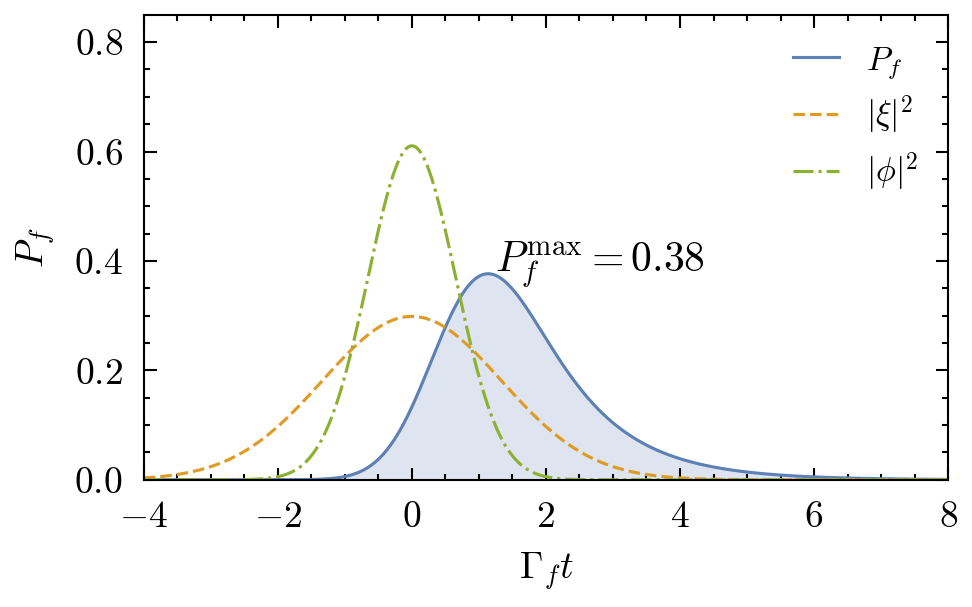

In [114]:
g1 = 1
g2 = 1 
o1 = 0.748468
o2 = 1.530213
Mu = 0
Experiment = L3.TwoPhoton(Gaussian, Gamma_1= g1, Omega_1= o1,
                          Gamma_2= g2, Omega_2= o2, Mu=Mu,  nBins = 1000,
                          # tol = 1e-5, status = 'vectorized' )#,tRange=[-3,4] )
                          tol = 1e-5, status = 'Uncorrelated_quad_paral',N_threads = 24 ,tRange=[-4,8] )

t, p = Experiment.P()

xi = np.abs(Experiment.xi(t,Omega = o1,Mu = 0))**2
phi = np.abs(Experiment.phi(t,Omega = o2,Mu = Mu))**2
plt.plot(t,p,label = r'$P_f$')
plt.fill_between(t,p,0,alpha = 0.2)
plt.plot(t,xi,label = r'$|\xi|^2$')
plt.plot(t,phi,label = r'$|\phi|^2$')

text1 = plt.text(t[np.argmax(p)]+ 0.1,p.max()*1.01,f'$P^{{\mathrm{{max}}}}_f = {p.max():.2f}$')
# text2 = plt.text(0.05, 0.80,f'$\Gamma_e =\Gamma_f = {g1:.1f}$\n$\Omega_1 = {s1:.3f}$\n$\Omega_2 = {s2:.3f}$\n$\Omega_2/\Omega_1 = {s2/s1:.3f}$\n$\mu = {Mu:.3f}$',transform=plt.gca().transAxes)
plt.xlabel(r'$\Gamma_f t$')
plt.ylabel(r'$P_f$')
plt.ylim(-0.0,0.85)
plt.xlim(-4,8)
plt.legend(frameon = False)
# plt.title('Uncorrelated case for the best choice of other parameters WITH DELAY')
plt.savefig('Uncorrelated_optimized_GammaEqual_withoutDelay.png')

In [46]:
# df_Uncor_Mu[30:50]

### Uncorrelated WITH Delay

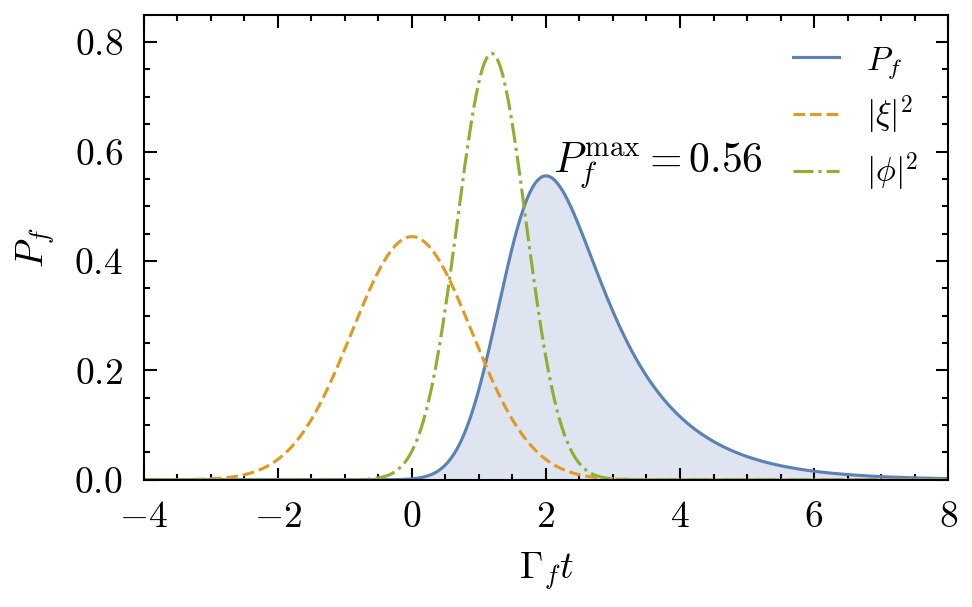

In [115]:
g1 = 1
g2 = 1 
o1 = 1.114106
o2 = 1.953034
Mu = 1.190817
Experiment = L3.TwoPhoton(Gaussian, Gamma_1= g1, Omega_1= o1,
                          Gamma_2= g2, Omega_2= o2, Mu=Mu,  nBins = 1000,
                          # tol = 1e-5, status = 'vectorized' )#,tRange=[-3,4] )
                          tol = 1e-5, status = 'Uncorrelated_quad_paral',N_threads = 24 ,tRange=[-4,8] )

t, p = Experiment.P()

xi = np.abs(Experiment.xi(t,Omega = o1,Mu = 0))**2
phi = np.abs(Experiment.phi(t,Omega = o2,Mu = Mu))**2
plt.plot(t,p,label = r'$P_f$')
plt.fill_between(t,p,0,alpha = 0.2)
plt.plot(t,xi,label = r'$|\xi|^2$')
plt.plot(t,phi,label = r'$|\phi|^2$')

text1 = plt.text(t[np.argmax(p)]+ 0.1,p.max()*1.01,f'$P^{{\mathrm{{max}}}}_f = {p.max():.2f}$')
# text2 = plt.text(0.05, 0.80,f'$\Gamma_e =\Gamma_f = {g1:.1f}$\n$\Omega_1 = {s1:.3f}$\n$\Omega_2 = {s2:.3f}$\n$\Omega_2/\Omega_1 = {s2/s1:.3f}$\n$\mu = {Mu:.3f}$',transform=plt.gca().transAxes)
plt.xlabel(r'$\Gamma_f t$')
plt.ylabel(r'$P_f$')
plt.ylim(-0.0,0.85)
plt.xlim(-4,8)
plt.legend(frameon = False)
# plt.title('Uncorrelated case for the best choice of other parameters WITH DELAY')
plt.savefig('Uncorrelated_optimized_GammaEqual_Delay.png')

## Heat Map
### Entangled Vs. Uncorrelated

In [51]:
# import numpy as np
# import multiprocessing as mp
# import matplotlib.pyplot as plt
# t0 = time()
# # Define your function
# def P_max(Mu,o1):
#     g1 = 5
#     g2 = 1
#     o2= 1
#     Experiment = L3.TwoPhoton(Gaussian, Gamma_1= g1, Omega_1= o1,
#                       Gamma_2= g2, Omega_2= o2, nBins = 100, Mu = Mu,
#                       tol = 1e-15, status = 'Correlated_quad' )
#     _, p = Experiment.P()
#     return p.max()

# # Define the ranges for Mu and Omega
# Mu = np.linspace(-2, 4, 100)
# Omega = np.linspace(0.01, 7, 100)

# Function to compute values in parallel
# def compute_values(chunk):
#     results = []
#     for Mu_val in chunk:
#         for Omega_val in Omega:
#             result = P_max(Mu_val, Omega_val)
#             results.append((Mu_val, Omega_val, result))
#     return results

# # Split Mu values into chunks for parallel processing
# num_processes = 22  # Number of available CPU cores
# chunk_size = len(Mu) // num_processes
# chunks = [Mu[i:i+chunk_size] for i in range(0, len(Mu), chunk_size)]

# # Perform parallel computation
# pool = mp.Pool(processes=num_processes)
# results = pool.map(compute_values, chunks)
# pool.close()
# pool.join()

# # Combine results from different processes
# all_results = [item for sublist in results for item in sublist]

# # Extract Mu, Omega, and function values from results
# Mu_values, Omega_values, function_values = zip(*all_results)

# # Reshape function values into a 2D array
# function_values = np.array(function_values).reshape(len(Mu), len(Omega))

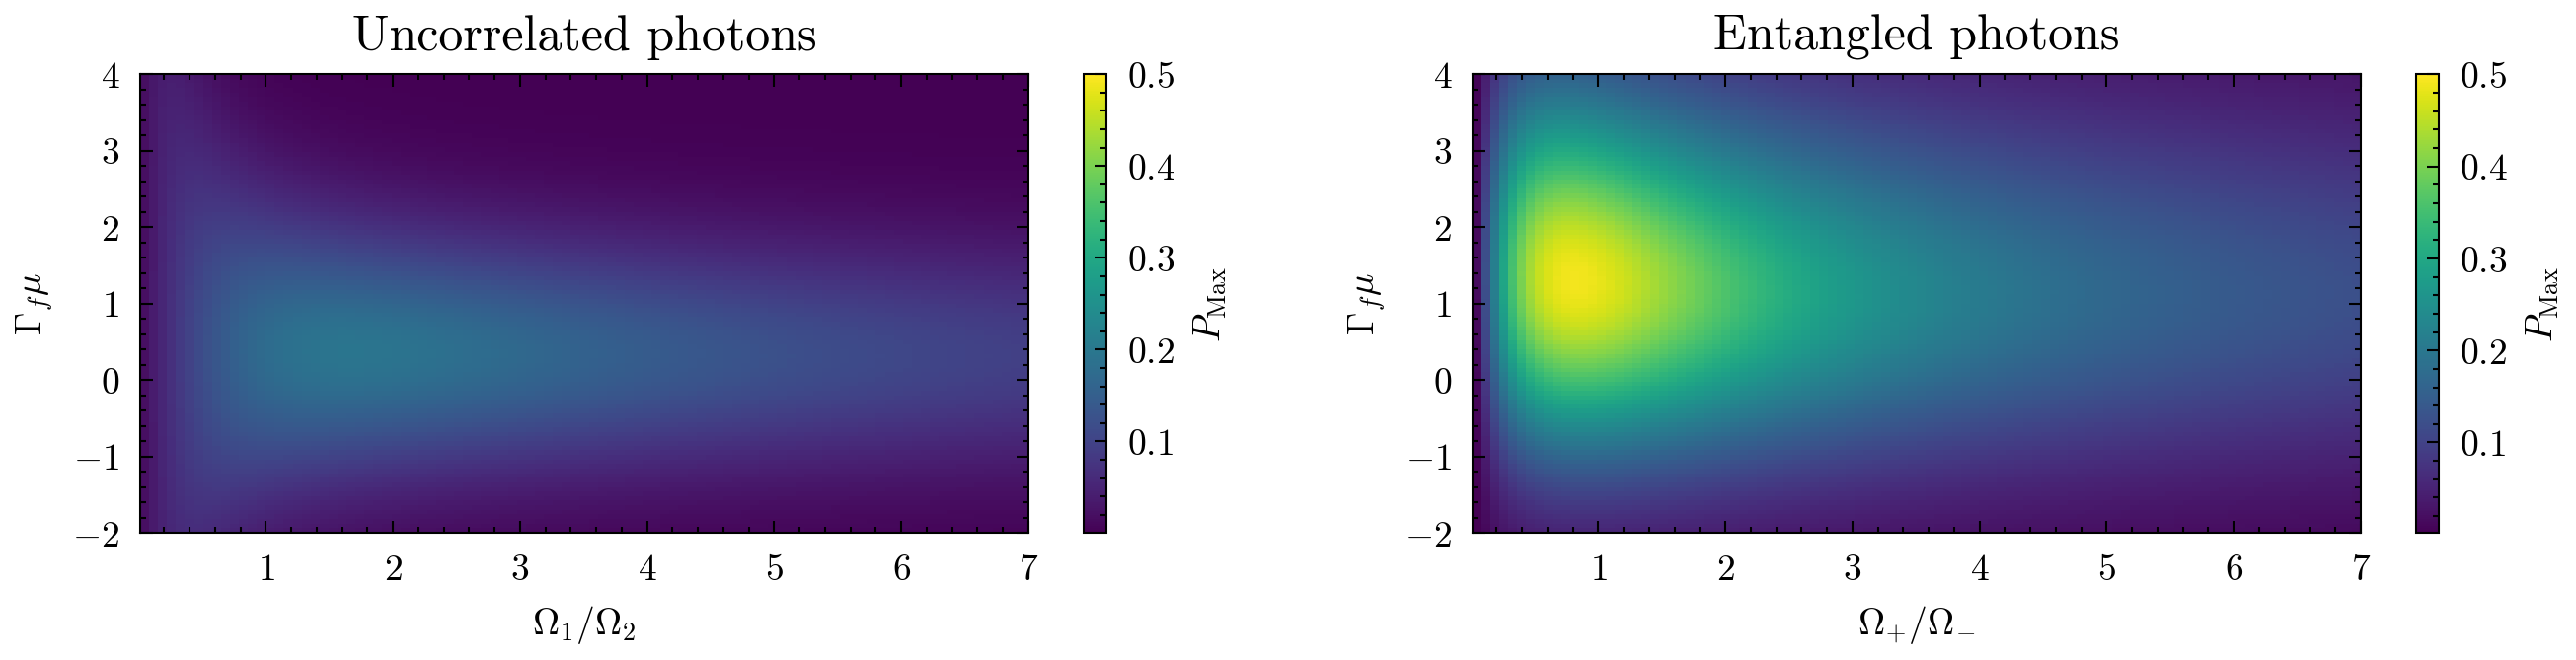

In [263]:
# np.savetxt('heatMap_correlated.txt',function_values)
Gaussian_correlated = np.loadtxt('dataSet/paper/heatMap_correlated_Mu_Omega_Gaussian.txt')
Gaussian_Uncorrelated = np.loadtxt('dataSet/paper/heatMap_Uncorrelated_MU_Omega_Gaussian.txt')
Gaussian_Uncorrelated = np.delete(Gaussian_Uncorrelated,0,axis=1)
Mu = np.linspace(-2, 4, 100)
Omega = np.linspace(0.01, 7, 100)

fig , ax= plt.subplots(1,2,figsize = (10,2))  

correlated = ax[0].imshow(Gaussian_Uncorrelated, origin = 'lower', extent=[Omega.min(), Omega.max(), Mu.min(), Mu.max()], vmax = 0.5, aspect='auto', cmap='viridis')
cbar = plt.colorbar(correlated)
cbar.set_label(f'$P_{{\mathrm{{Max}}}}$')
ax[0].set_title('Uncorrelated photons')
ax[0].set_xlabel(r'$\Omega_{1}/\Omega_{2}$')
ax[0].set_ylabel(r'$\Gamma_f \mu$')
Uncorrelated = ax[1].imshow(Gaussian_correlated, origin = 'lower', extent=[Omega.min(), Omega.max(), Mu.min(), Mu.max()], vmax = 0.5, aspect='auto', cmap='viridis')
cbar = plt.colorbar(Uncorrelated)
cbar.set_label(f'$P_{{\mathrm{{Max}}}}$')
ax[1].set_title('Entangled photons')
ax[1].set_xlabel(r'$\Omega_{+}/\Omega_{-}$' )
ax[1].set_ylabel(r'$\Gamma_f \mu$')
# plt.savefig('P_Omega_Mu_g5.png',dpi = 300)
plt.show()


In this Fig. we compare two 'Entangled' and 'Uncorrelatred' photon consifering $\Gamma_e/\Gamma_f = 5$. In these cases we do not indclude the time delay.

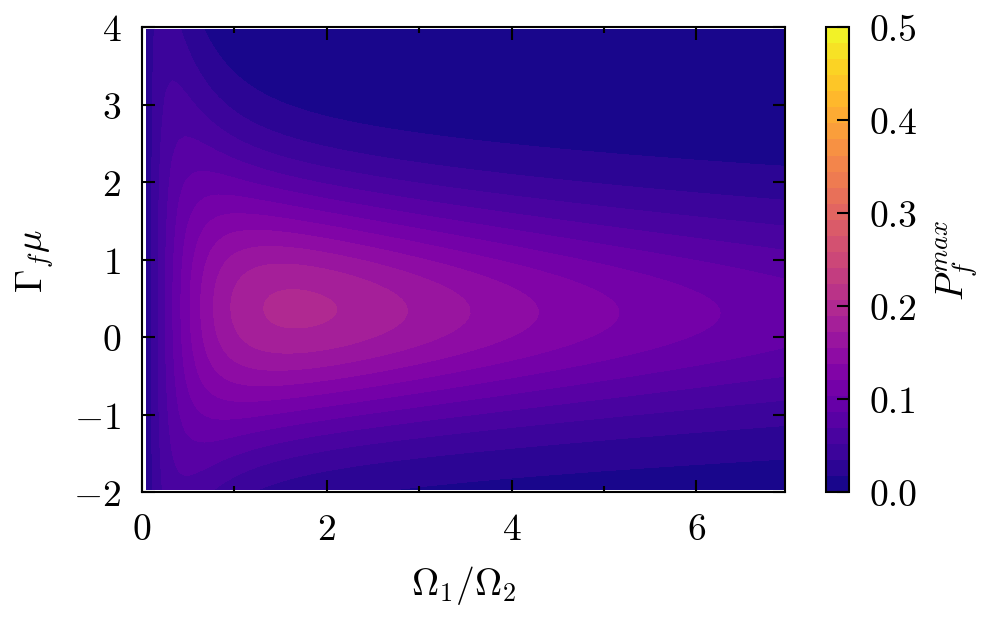

In [272]:

fig , ax= plt.subplots()  


correlated = ax.contourf(Gaussian_Uncorrelated, origin = 'lower',levels=np.linspace(0,0.5, 30), extent=[Omega.min(), Omega.max(), Mu.min(), Mu.max()], aspect='auto', cmap='plasma')
cbar = plt.colorbar(correlated)
cbar.set_label(r'$P_f^{max}$')
cbar.set_ticks(np.arange(0,0.51,0.1))
cbar.set_ticklabels(np.round(np.arange(0,0.51,0.1),1))

# cbar.set_label(f'$P_{{\mathrm{{max}}}}$')
# ax.set_title('Uncorrelated photons')
# ax.set_xlim(Omega.min(),6.5)
ax.set_xlabel(r'$\Omega_{1}/\Omega_{2}$')
ax.set_ylabel(r'$\Gamma_f \mu$')
ax.set_xticks(np.arange(0,6.5,2))
ax.set_yticks(np.arange(-2,4.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
# plt.savefig('P_Uncor_Omega_Mu_g5.png',dpi = 300)


0.4916079935137282

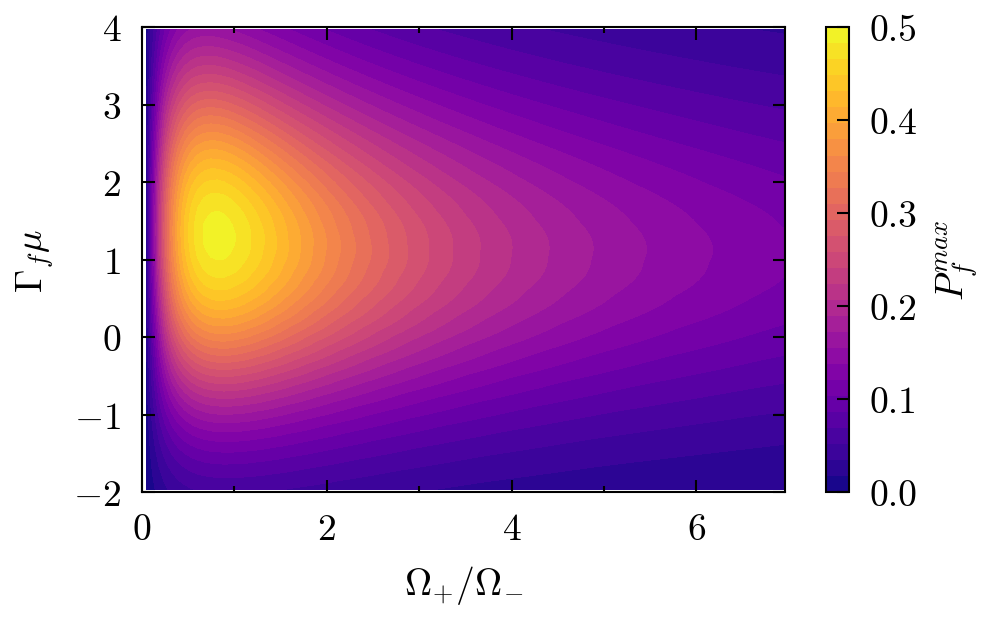

In [273]:

fig , ax= plt.subplots()  


correlated = ax.contourf(Gaussian_correlated, origin = 'lower',levels=np.linspace(0,0.5, 30), extent=[Omega.min(), Omega.max(), Mu.min(), Mu.max()], aspect='auto', cmap='plasma')
cbar = plt.colorbar(correlated)
cbar.set_label(r'$P_f^{max}$')
cbar.set_ticks(np.arange(0,0.51,0.1))
cbar.set_ticklabels(np.round(np.arange(0,0.51,0.1),1))

# cbar.set_label(f'$P_{{\mathrm{{max}}}}$')
# ax.set_title('Uncorrelated photons')
# ax.set_xlim(Omega.min(),6.5)
ax.set_xlabel(r'$\Omega_{+}/\Omega_{-}$')
ax.set_ylabel(r'$\Gamma_f \mu$')
ax.set_xticks(np.arange(0,6.5,2))
ax.set_yticks(np.arange(-2,4.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.savefig('P_Corr_Omega_Mu_g5.png',dpi = 300)
Gaussian_correlated.max()

## Heat map of $P_{max}$ vs $\Delta_1$ and $\Delta_2$

This plot is for the Gaussian pulse with following specifications:
1.0303360780276396, 10.425280342877375


For Entangled

| $\Gamma_e$ | $\Gamma_f$ | $\Omega_+$ | $\Omega_-$ |    $\mu$    |  $P_{max}$  |
|------------|------------|------------|------------|-------------|-------------|
| 0.5        | 1          | 0.78826     | 1.38264   | 1.618855    | 0.555524    |
| 1          | 1          | 0.9185     | 2.3377     |  0.915395   | 0.6095      |
| 5          | 1          | 1.0304     | 10.425     |  0.198731   |             |
| 20         | 1          | 1.054440205| 41.425497  |  0.04992066 | 0.04992066  |


For Uncorrelated Gaussian:


| $\Gamma_e$ | $\Gamma_f$ | $\Omega_+$ | $\Omega_-$ |    $\mu$    |  $P_{max}$  |
|------------|------------|------------|------------|-------------|-------------|
| 1          | 1          | 1.114106   | 1.953034   | 1.190817    | 0.555523    |
| 20         | 1          | 7.671800362| 7.949991361| 0.092538804 | 0.128       |

1.114106, 1.953034

For ***Coherent*** Gaussian:


| $\Gamma_e$ | $\Gamma_f$ | $\Omega_+$ | $\Omega_-$ |    $\mu$    |  $P_{max}$  |
|------------|------------|------------|------------|-------------|-------------|
| 1          | 1          | 1.766938   | 2.813221   | 0.680196    | 0.21406     |
| 20         | 1          | 7.240      | 9.043      | 0.04312    | 0.055988   |

For the left and right plot respectively. Both pulses are optimized.


In [209]:
# # np.savetxt('heatMap_correlated_Delta.txt',P_values_D)
# P_values_D = res_G5
# P_values_D = np.loadtxt('dataSet/paper/heatMap_P_Delta_Gaussian_G5.txt')

# D_max = 5
# D_min = -D_max
# # D_min = -5
# # fig , ax= plt.subplots(1,2,figsize = (18,7))  
# fig , ax= plt.subplots(figsize = (3.5,2.5))  

# G5 = ax.contourf(P_values_D, origin = 'lower', levels=np.linspace(0,0.65, 20), extent=[D_min, D_max, D_min, D_max], vmax = 0.65,aspect='auto', cmap='plasma')
# cbar = plt.colorbar(G5)
# cbar.set_label(f'$P_{{\mathrm{{Max}}}}$')
# cbar.set_ticks(np.arange(0,0.65,0.1))
# cbar.set_ticklabels(np.round(np.arange(0,0.65,0.1),1))
# ax.set_xlabel(r'$\Delta_1$')
# ax.set_ylabel(r'$\Delta_2$')
# ax.set_title(r'Optimum for $\Gamma_e = 5$')
# # plt.savefig('P_Delta_G5.png',dpi = 300)

# plt.show()
# print(P_values_D.max())


# P_values_D = np.loadtxt('dataSet/paper/heatMap_P_Delta_Gaussian_G1.txt')
# # P_values_D = np.loadtxt('dataSet/paper/P_Delta_g1.txt')
# # D_min = -3
# # D_max = 3
# fig , ax= plt.subplots(figsize = (3.5,2.5))  

# G1 = ax.contourf(P_values_D, origin = 'lower', levels=np.linspace(0,0.65, 20), extent=[D_min, D_max, D_min, D_max], vmax = 0.65, aspect='auto', cmap='plasma')
# cbar = plt.colorbar(G1)
# cbar.set_label(f'$P_{{\mathrm{{Max}}}}$')
# cbar.set_ticks(np.arange(0,0.65,0.1))
# cbar.set_ticklabels(np.round(np.arange(0,0.65,0.1),1))
# ax.set_xlabel(r'$\Delta_1$')
# ax.set_ylabel(r'$\Delta_2$')
# ax.set_title(r'Optimum for $\Gamma_e = 1$')

# # plt.savefig('P_Delta_G1.png',dpi = 300)

# plt.show()



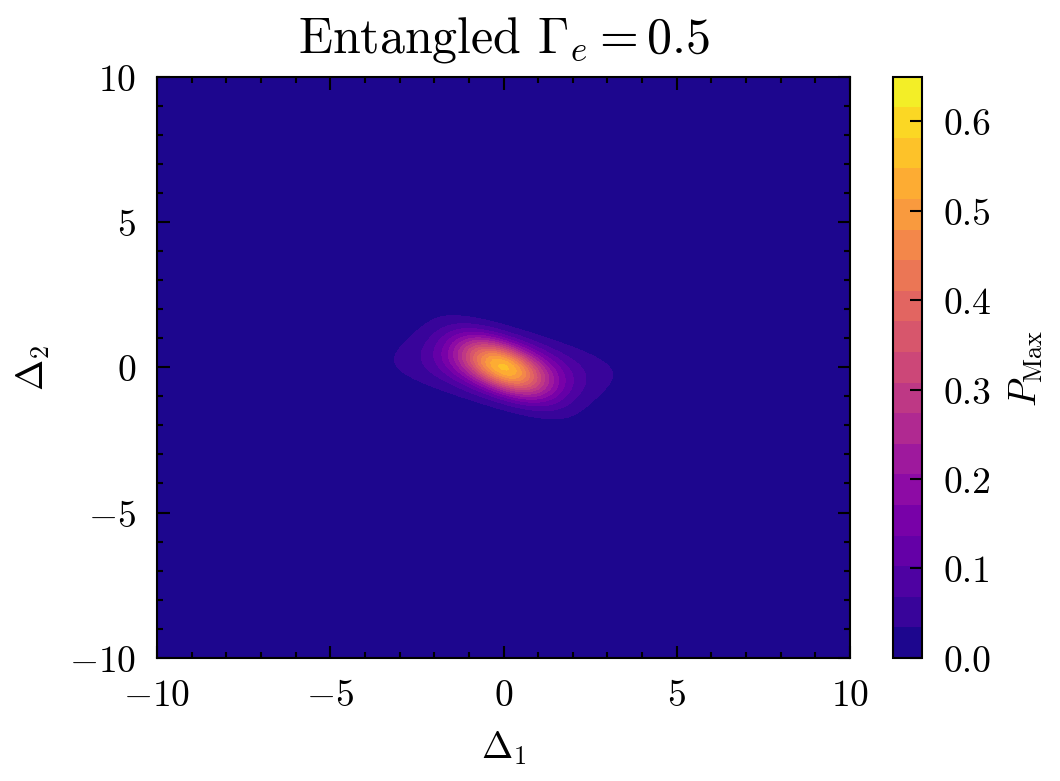

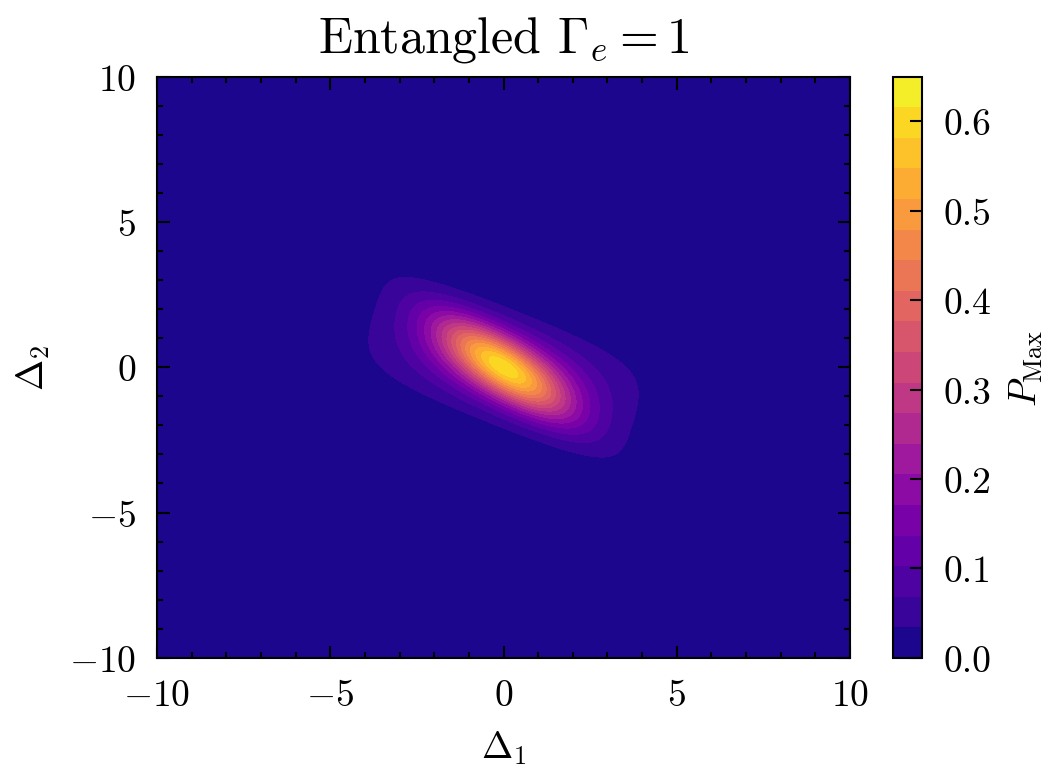

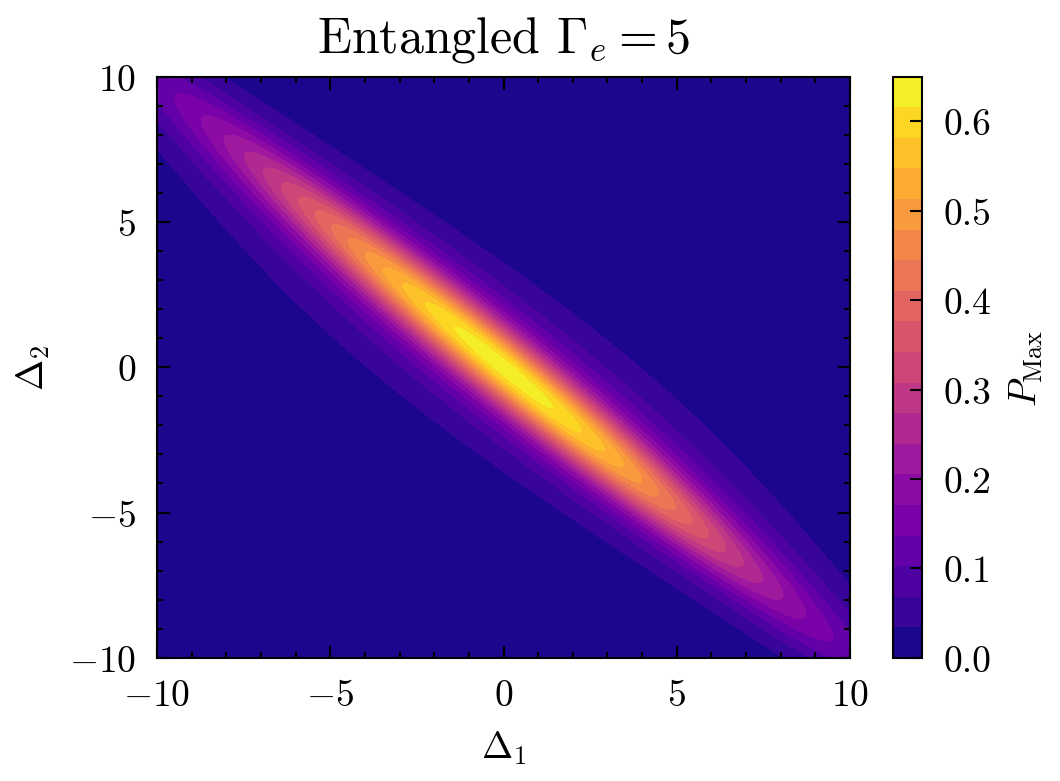

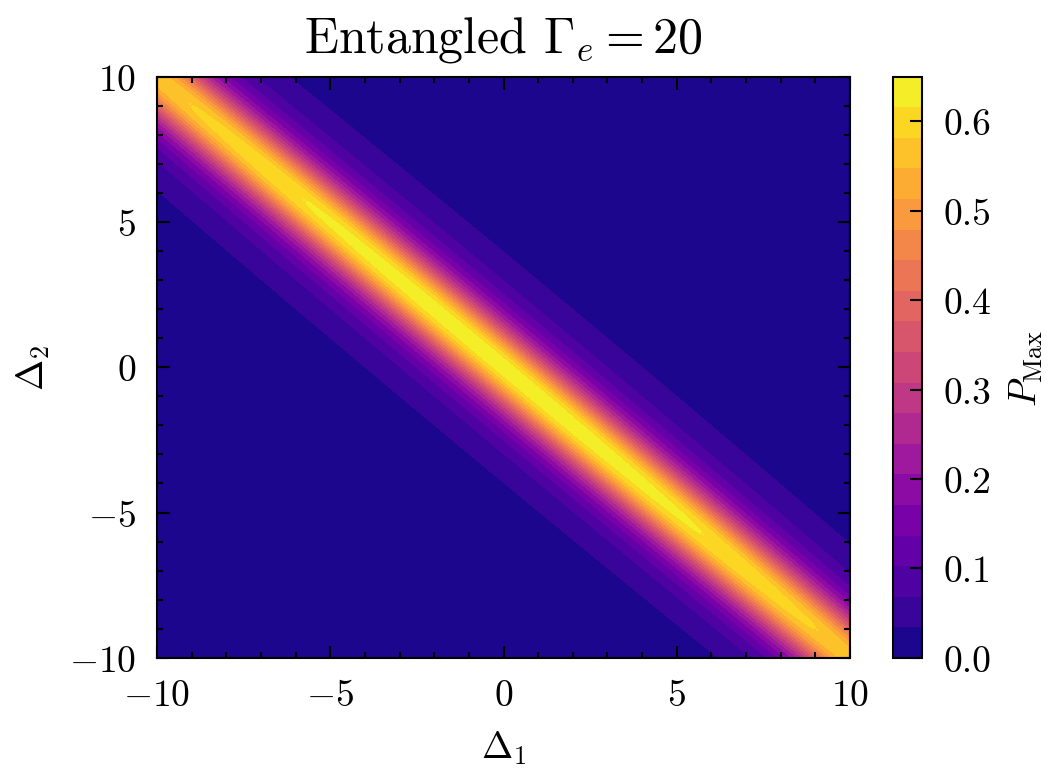

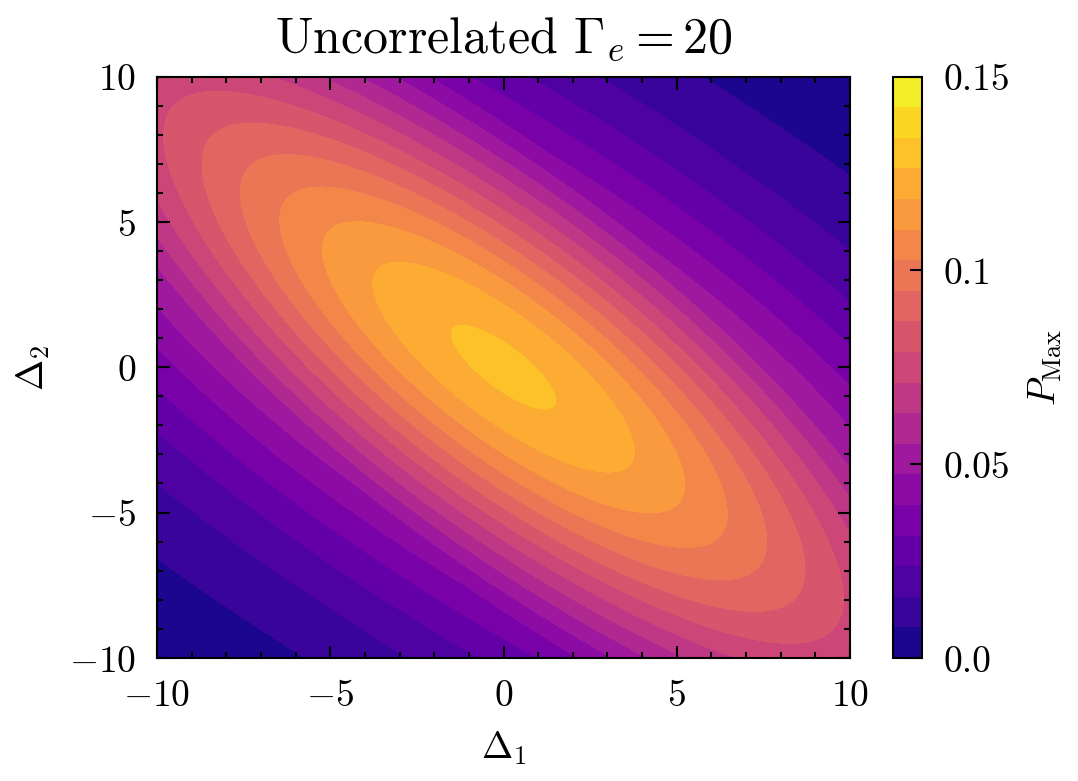

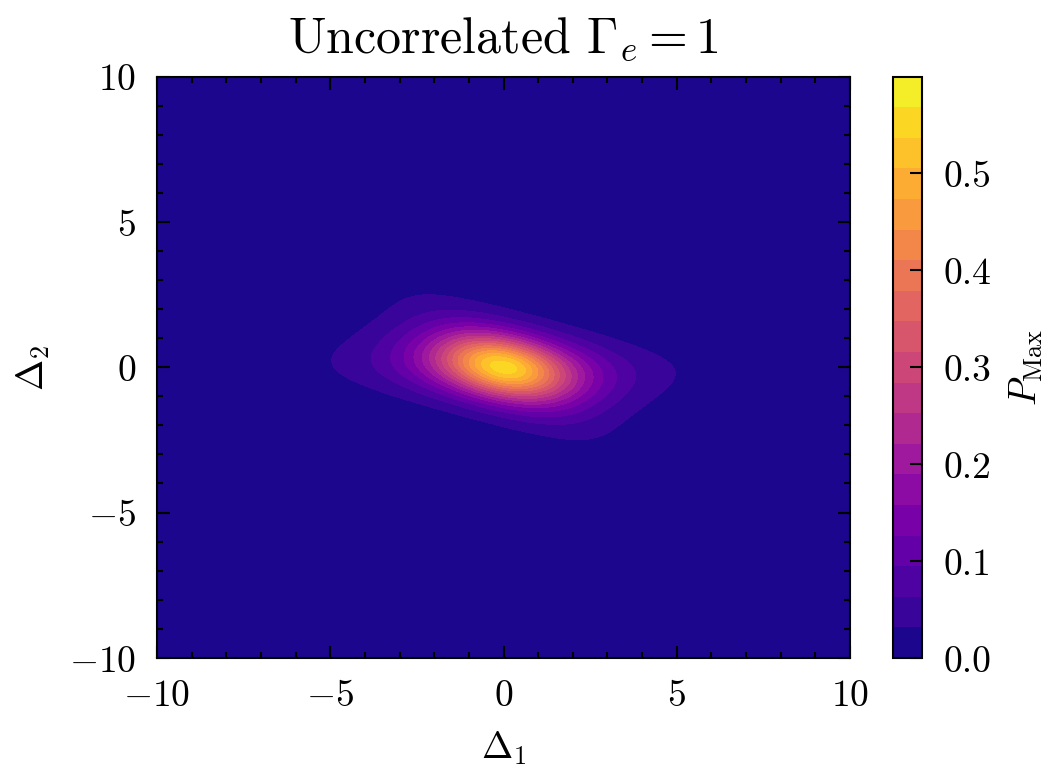

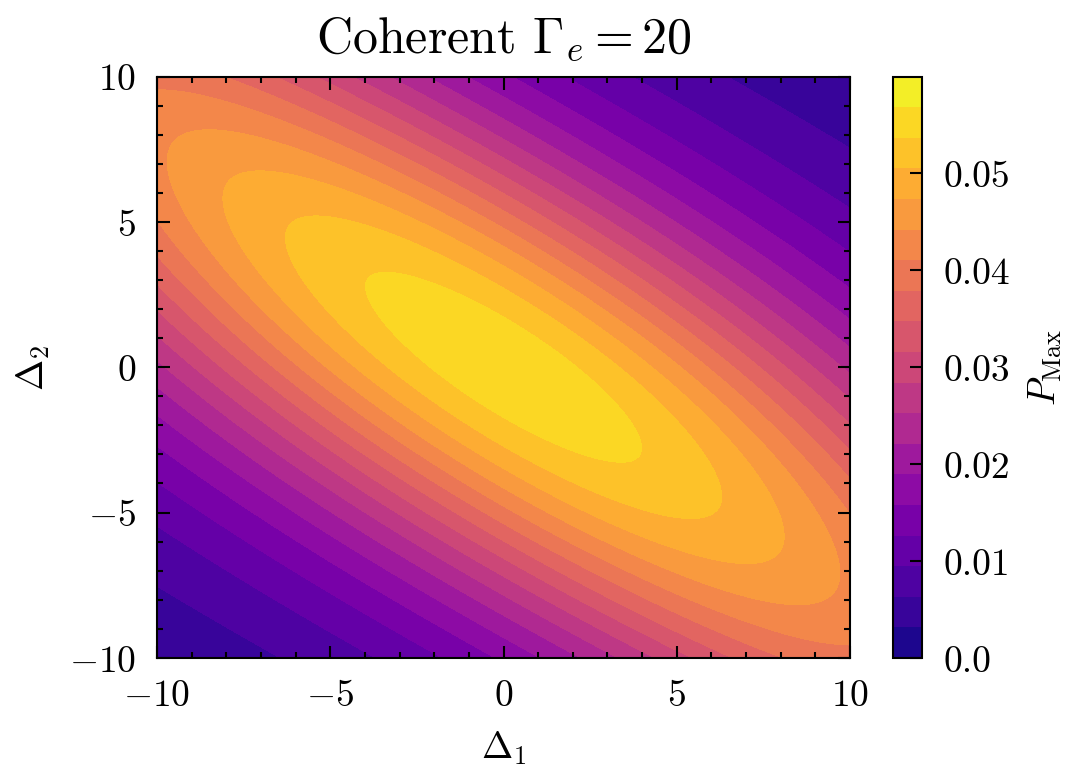

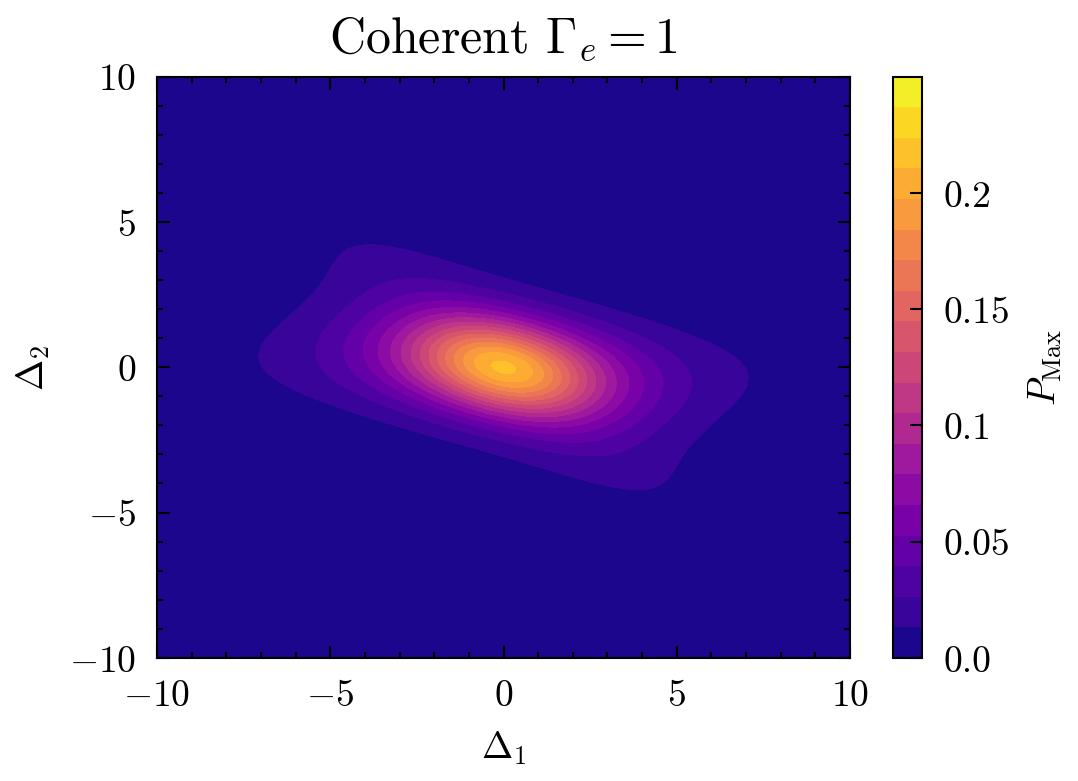

np.complex128(0.213428561174389+0j)

In [148]:
D_max = 10
D_min = -D_max
# D_min = -5

P_values_D = np.loadtxt('dataSet/P_Delta_G05.txt')
fig , ax= plt.subplots(figsize = (3.5,2.5))  

G1 = ax.contourf(P_values_D, origin = 'lower', levels=np.linspace(0,0.65, 20), extent=[D_min, D_max, D_min, D_max], vmax = 0.65, aspect='auto', cmap='plasma')
cbar = plt.colorbar(G1)
cbar.set_label(f'$P_{{\mathrm{{Max}}}}$')
cbar.set_ticks(np.arange(0,0.65,0.1))
cbar.set_ticklabels(np.round(np.arange(0,0.65,0.1),1))
ax.set_xticks(np.arange(-10,10.1,5))
ax.set_yticks(np.arange(-10,10.1,5))
ax.set_xlabel(r'$\Delta_1$')
ax.set_ylabel(r'$\Delta_2$')
ax.set_title(r'Entangled $\Gamma_e = 0.5$')

# plt.savefig('dataSet/paper/P_Entangled_G05.png',dpi = 300)
plt.show()


P_values_D = np.loadtxt('dataSet/P_Delta_G1.txt')
fig , ax= plt.subplots(figsize = (3.5,2.5))  

G1 = ax.contourf(P_values_D, origin = 'lower', levels=np.linspace(0,0.65, 20), extent=[D_min, D_max, D_min, D_max], vmax = 0.65, aspect='auto', cmap='plasma')
cbar = plt.colorbar(G1)
cbar.set_label(f'$P_{{\mathrm{{Max}}}}$')
cbar.set_ticks(np.arange(0,0.65,0.1))
cbar.set_ticklabels(np.round(np.arange(0,0.65,0.1),1))
ax.set_xticks(np.arange(-10,10.1,5))
ax.set_yticks(np.arange(-10,10.1,5))
ax.set_xlabel(r'$\Delta_1$')
ax.set_ylabel(r'$\Delta_2$')
ax.set_title(r'Entangled $\Gamma_e = 1$')

# plt.savefig('dataSet/paper/P_Entangled_G1.png',dpi = 300)
plt.show()


P_values_D = np.loadtxt('dataSet/P_Delta_G5.txt')
fig , ax= plt.subplots(figsize = (3.5,2.5))  

G5 = ax.contourf(P_values_D, origin = 'lower', levels=np.linspace(0,0.65, 20), extent=[D_min, D_max, D_min, D_max], vmax = 0.65,aspect='auto', cmap='plasma')
cbar = plt.colorbar(G5)
cbar.set_label(f'$P_{{\mathrm{{Max}}}}$')
cbar.set_ticks(np.arange(0,0.65,0.1))
cbar.set_ticklabels(np.round(np.arange(0,0.65,0.1),1))
ax.set_xticks(np.arange(-10,10.1,5))
ax.set_yticks(np.arange(-10,10.1,5))
ax.set_xlabel(r'$\Delta_1$')
ax.set_ylabel(r'$\Delta_2$')
ax.set_title(r'Entangled $\Gamma_e = 5$')
# plt.savefig('dataSet/paper/P_Entangled_G5.png',dpi = 300)

plt.show()




P_values_D = np.loadtxt('dataSet/P_Delta_G20.txt')
fig , ax= plt.subplots(figsize = (3.5,2.5))  

G1 = ax.contourf(P_values_D, origin = 'lower', levels=np.linspace(0,0.65, 20), extent=[D_min, D_max, D_min, D_max], vmax = 0.65, aspect='auto', cmap='plasma')
cbar = plt.colorbar(G1)
cbar.set_label(f'$P_{{\mathrm{{Max}}}}$')
cbar.set_ticks(np.arange(0,0.65,0.1))
cbar.set_ticklabels(np.round(np.arange(0,0.65,0.1),1))
ax.set_xticks(np.arange(-10,10.1,5))
ax.set_yticks(np.arange(-10,10.1,5))
ax.set_xlabel(r'$\Delta_1$')
ax.set_ylabel(r'$\Delta_2$')
ax.set_title(r'Entangled $\Gamma_e = 20$')

# plt.savefig('dataSet/paper/P_Entangled_G20.png',dpi = 300)
plt.show()


P_values_D = np.loadtxt('dataSet/P_Delta_G20_Uncor.txt')
fig , ax= plt.subplots(figsize = (3.5,2.5))  

G1 = ax.contourf(P_values_D, origin = 'lower', levels=np.linspace(0,0.15, 20), extent=[D_min, D_max, D_min, D_max], vmax = 0.15, aspect='auto', cmap='plasma')
# G1 = ax.imshow(P_values_D, origin = 'lower', extent=[D_min, D_max, D_min, D_max], vmax = 0.15, aspect='auto', cmap='plasma')
cbar = plt.colorbar(G1)
cbar.set_label(f'$P_{{\mathrm{{Max}}}}$')
cbar.set_ticks(np.arange(0,0.155,0.05))
cbar.set_ticklabels(np.round(np.arange(0,0.155,0.05),2))
ax.set_xticks(np.arange(-10,10.1,5))
ax.set_yticks(np.arange(-10,10.1,5))
ax.set_xlabel(r'$\Delta_1$')
ax.set_ylabel(r'$\Delta_2$')
ax.set_title(r'Uncorrelated $\Gamma_e = 20$')

# plt.savefig('dataSet/paper/P_Uncorr_G20.png',dpi = 300)
plt.show()


P_values_D = np.loadtxt('dataSet/P_Delta_G1_Uncor.txt')
fig , ax= plt.subplots(figsize = (3.5,2.5))  

G1 = ax.contourf(P_values_D, origin = 'lower', levels=np.linspace(0,0.6, 20), extent=[D_min, D_max, D_min, D_max], vmax = 0.6, aspect='auto', cmap='plasma')
# G1 = ax.imshow(P_values_D, origin = 'lower', extent=[D_min, D_max, D_min, D_max], vmax = 0.15, aspect='auto', cmap='plasma')
cbar = plt.colorbar(G1)
cbar.set_label(f'$P_{{\mathrm{{Max}}}}$')
cbar.set_ticks(np.arange(0,0.6,0.1))
cbar.set_ticklabels(np.round(np.arange(0,0.6,0.1),1))
ax.set_xticks(np.arange(-10,10.1,5))
ax.set_yticks(np.arange(-10,10.1,5))
ax.set_xlabel(r'$\Delta_1$')
ax.set_ylabel(r'$\Delta_2$')
ax.set_title(r'Uncorrelated $\Gamma_e = 1$')

# plt.savefig('dataSet/paper/P_Uncorr_G1.png',dpi = 300)
plt.show()
# print( 'G! Uncorr:' , P_values_D.max())

P_values_D = np.genfromtxt('dataSet/P_Delta_G20_Coherent.txt', dtype=complex)
fig , ax= plt.subplots(figsize = (3.5,2.5))  

G1 = ax.contourf(P_values_D, origin = 'lower', levels=np.linspace(0,0.06, 20), extent=[D_min, D_max, D_min, D_max], vmax = 0.06, aspect='auto', cmap='plasma')
# G1 = ax.imshow(P_values_D, origin = 'lower', extent=[D_min, D_max, D_min, D_max], vmax = 0.6, aspect='auto', cmap='plasma')
cbar = plt.colorbar(G1)
cbar.set_label(f'$P_{{\mathrm{{Max}}}}$')
cbar.set_ticks(np.arange(0,0.06,0.01))
cbar.set_ticklabels(np.round(np.arange(0,0.06,0.01),2))
ax.set_xticks(np.arange(-10,10.1,5))
ax.set_yticks(np.arange(-10,10.1,5))
ax.set_xlabel(r'$\Delta_1$')
ax.set_ylabel(r'$\Delta_2$')
ax.set_title(r'Coherent $\Gamma_e = 20$')

# plt.savefig('dataSet/paper/P_Coherent_G20.png',dpi = 300)
plt.show()

P_values_D = np.genfromtxt('dataSet/P_Delta_G1_Coherent.txt', dtype=complex)
fig , ax= plt.subplots(figsize = (3.5,2.5))  

G1 = ax.contourf(P_values_D, origin = 'lower', levels=np.linspace(0,0.25, 20), extent=[D_min, D_max, D_min, D_max], vmax = 0.25, aspect='auto', cmap='plasma')
# G1 = ax.imshow(P_values_D, origin = 'lower', extent=[D_min, D_max, D_min, D_max], vmax = 0.6, aspect='auto', cmap='plasma')
cbar = plt.colorbar(G1)
cbar.set_label(f'$P_{{\mathrm{{Max}}}}$')
cbar.set_ticks(np.arange(0,0.25,0.05))
cbar.set_ticklabels(np.round(np.arange(0,0.25,0.05),2))
ax.set_xticks(np.arange(-10,10.1,5))
ax.set_yticks(np.arange(-10,10.1,5))
ax.set_xlabel(r'$\Delta_1$')
ax.set_ylabel(r'$\Delta_2$')
ax.set_title(r'Coherent $\Gamma_e = 1 $')

# plt.savefig('dataSet/paper/P_Coherent_G1.png',dpi = 300)
plt.show()

P_values_D.max()


In [156]:
G1.shape

AttributeError: 'QuadContourSet' object has no attribute 'shape'

In [26]:
data = np.genfromtxt('dataSet/P_Delta_G20_Coherent.txt', dtype=complex)
print(data.shape)

data[np.imag(data) != 0]

(200, 201)


array([], dtype=complex128)

## $P_{max}$ vs $\Gamma_e/\Gamma_f$ for Reactangular pulse

### Uncorrelated

In [275]:
df_Unc_Rec = pd.read_csv('dataSet/paper/Uncorrelated_Rectangular_withoutMU.csv')
df_Unc_Rec_Mu = pd.read_csv('dataSet/paper/Uncorrelated_Rectangular_MU.csv')


plt.plot(df_Unc_Rec_Mu['Gamma_e'], df_Unc_Rec_Mu['P_max'],'-',label = r'$\mu \neq 0$')
plt.plot(df_Unc_Rec['Gamma_e'], df_Unc_Rec['P_max'],'-.',label = r'$\mu = 0$')

plt.xlabel(r'$\Gamma_e/\Gamma_f$')
plt.ylabel(r'$P_f^{max}$')
plt.ylim(-0.01,0.7)
plt.xlim(-0.15,9.5)

plt.legend(frameon=False)


FileNotFoundError: [Errno 2] No such file or directory: 'dataSet/paper/Uncorrelated_Rectangular_withoutMU.csv'

In [98]:
df_Unc_Rec

## $P_{max}$ vs $\Gamma_e/\Gamma_f$ for Gaussian 

### Entangled

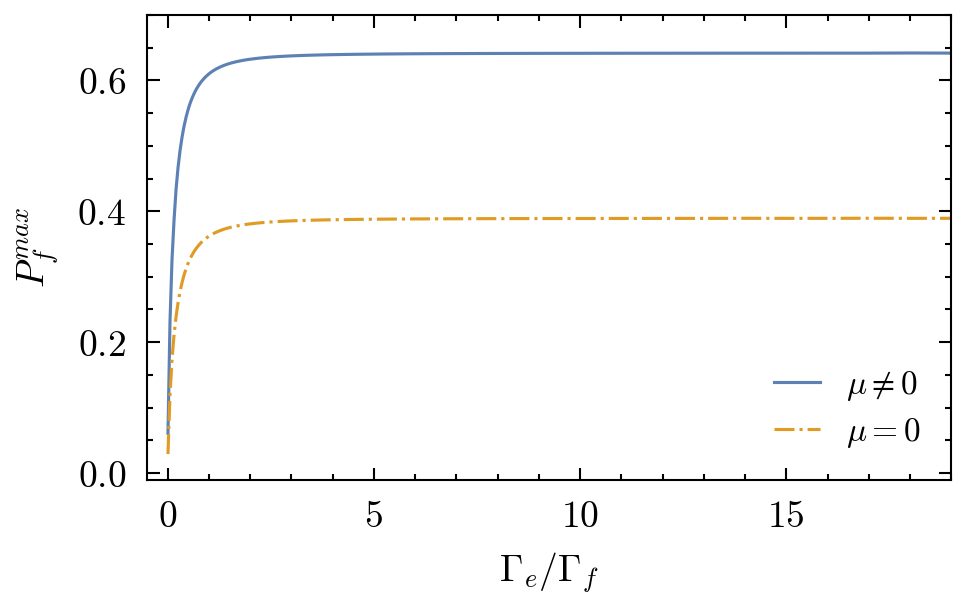

In [36]:
df_Ent = pd.read_csv('dataSet/paper/P_Entangled_Gaussian.csv')
df_Ent.reset_index(inplace=True,drop=True)
df_Ent_Mu = pd.read_csv('dataSet/paper/P_Entangled_Gaussian_Mu.csv')
df_Ent_Mu.reset_index(inplace=True,drop=True)


plt.plot(df_Ent_Mu['Gamma_e'], df_Ent_Mu['P_max'],'-',label = r'$\mu \neq 0$')
plt.plot(df_Ent['Gamma_e'], df_Ent['P_max'],'-.',label = r'$\mu = 0$')

plt.xlabel(r'$\Gamma_e/\Gamma_f$')
plt.ylabel(r'$P_f^{max}$')
plt.ylim(-0.01,0.7)
plt.xlim(-0.5,19)
# plt.title('Entangled')
plt.legend(frameon=False)
# plt.savefig('Entangled.eps')

In [146]:
# df_Ent_Mu[10:60]

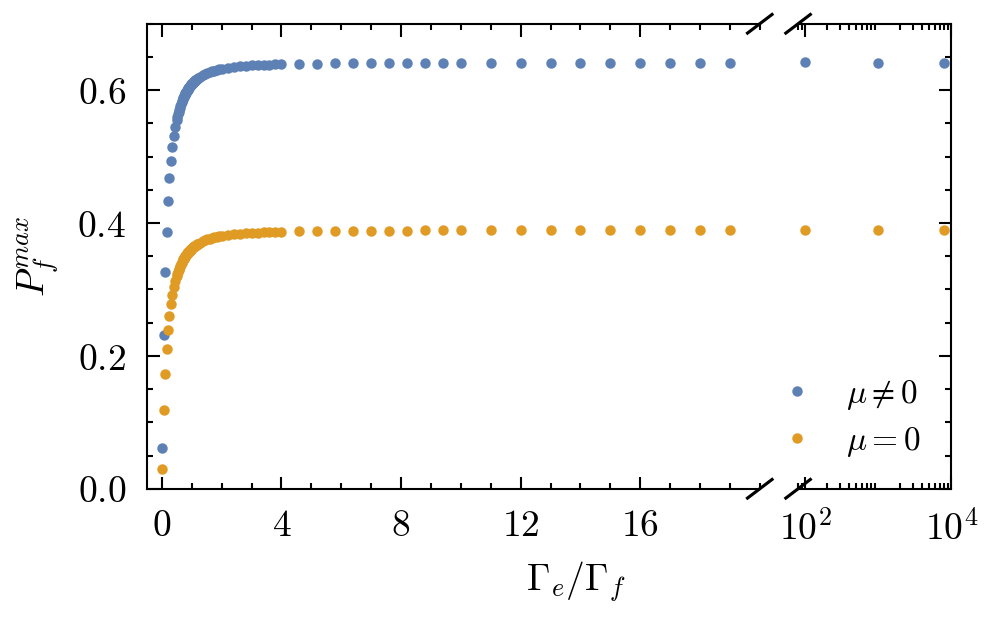

In [4]:
import matplotlib.pyplot as plt
import numpy as np

x2 = [100, 1000, 8000]              # x at 100 and 1000
P_withMu = [0.641704767, 0.64141003027, 0.64148]              # Replace with your actual data
P_withoutMu = [0.38944, 0.3896677609, 0.389303]              # Replace with your actual data

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w', gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.1})

# Plot the first range (0 to 10)
ax.plot(df_Ent_Mu['Gamma_e'], df_Ent_Mu['P_max'],'.',label = r'$\mu \neq 0$')
ax.plot(df_Ent['Gamma_e'], df_Ent['P_max'],'.',label = r'$\mu = 0$')
ax.set_xlim(-0.5, 20)
ax.set_xticks(np.arange(0, 20, 4))
ax.set_ylim(0,0.7)
ax.spines['right'].set_visible(False)
ax.yaxis.tick_left()
ax.set_xlabel(r'$\Gamma_e/\Gamma_f$')
ax.xaxis.set_label_coords(0.7,-0.15)
ax.set_ylabel(r'$P_f^{max}$')
# ax.grid(True)

# Plot the second range (100 and 1000)
ax2.semilogx(x2, P_withMu,'.',label = r'$\mu \neq 0$')
ax2.semilogx(x2, P_withoutMu,'.',label = r'$\mu = 0$')
ax2.set_xlim(80, 8000)
ax2.set_xticks([100,10000])
ax2.spines['left'].set_visible(False)
ax2.yaxis.tick_right()

# ax2.grid(True)




d = .02  # size of the break markers
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, linestyle = 'solid')
ax.plot((1-d, 1+d), (-d, +d), **kwargs)
ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-4*d, +4*d), (-d, +d), **kwargs)
ax2.plot((-4*d, +4*d), (1-d, 1+d), **kwargs)
ax2.legend(loc='lower right')
# Add some space between the subplots for better visual separation
# plt.savefig('Entangled_Gaussian.png',dpi = 300)
plt.show()


| $P_{max}$ | $\Gamma_e$ | $\Gamma_f$ | $\Omega_+$ | $\Omega_-$ |    $\mu$    |
|------------|------------|------------|------------|------------|-------------|
| 0.389450  | 100    | 1     | 1.02324     | 108.294854     |  0   |
| 0.6417047 | 100    | 1     | 1.026218     | 207.17990     |  0.009955146   |
| 0.389667  | 1000   | 1      | 1.0407     | 1076.1004551     |  0         |
| 0.6414100 | 1000   | 1      | 1.02816     | 1995.48483     | 0.0010182678  |
| 0.389303   | 8000   | 1      | 1.0407     | 8608.8     | 0  |
| 0.64148   | 8000   | 1      | 1.026218     | 16561.432     | 0.000124439  |




In [112]:
# new_row = {'P_max': [0.6417047, 0.6414100, 0.64148 ], 'Omega_1': [1.02621, 1.0281, 1.02621], 'Omega_2': [207.1799, 1995.48, 16561.432], 'Mu': [0.009955, 0.00101826, 0.000124439], 'Gamma_e': [100, 1000, 8000], 'Shannon': [0, 0, 0]}
# # new_row = {'P_max': [0.389450, 0.389667, 0.389303 ], 'Omega_1': [1.02324, 1.0407, 1.0407], 'Omega_2': [108.29485, 1076.10045, 8608.8],  'Gamma_e': [100, 1000, 8000], 'Shannon': [0, 0, 0]}
# df_Ent_Mu = pd.concat([df_Ent_Mu,pd.DataFrame(new_row)],ignore_index=True)
# df_Ent_Mu['Shannon'] = Shannon(df_Ent_Mu['Omega_1'],df_Ent_Mu['Omega_2'])
# df_Ent_Mu.to_csv('dataSet/paper/P_Entangled_Gaussian_Mu.csv',index_label=False)
# # # df_Uncor_Mu
df_Ent_Mu[-30:-10]

,P_max,Omega_1,Omega_2,Mu,Gamma_e,Shannon
73,0.635822,1.008275,5.509242,0.377908,2.6,1.908822
74,0.636584,1.015212,5.915242,0.351788,2.8,1.999559
75,0.637210,1.016642,6.321012,0.328928,3.0,2.091511
76,0.637726,1.017813,6.727620,0.308834,3.2,2.178351
77,0.638156,1.018788,7.134979,0.291034,3.4,2.260575
78,0.638517,1.019612,7.543174,0.275157,3.6,2.338649
79,0.638824,1.020309,7.951687,0.260915,3.8,2.412880
80,0.639086,1.020894,8.360892,0.248063,4.0,2.483699
81,0.639686,1.027711,9.591381,0.216139,4.6,2.670526
82,0.640094,1.028650,10.823400,0.191434,5.2,2.842372


In [72]:
# new_row = {'P_max': [0.6417047, 0.6414100, 0.64148 ], 'Omega_1': [1.02621, 1.0281, 1.02621], 'Omega_2': [207.1799, 1995.48, 16561.432], 'Mu': [0.009955, 0.00101826, 0.000124439], 'Gamma_e': [100, 1000, 8000], 'Shannon': [0, 0, 0]}
# df_Ent_Mu_ext = pd.concat([df_Ent_Mu,pd.DataFrame(new_row)],ignore_index=True)

# new_row = {'P_max': [0.389450, 0.389667, 0.389303 ], 'Omega_1': [1.02324, 1.0407, 1.0407], 'Omega_2': [108.29485, 1076.10045, 8608.8],  'Gamma_e': [100, 1000, 8000], 'Shannon': [0, 0, 0]}
# df_Ent_ext = pd.concat([df_Ent,pd.DataFrame(new_row)],ignore_index=True)


# fig, ax = plt.subplots()

# ax.semilogx(df_Ent_Mu_ext['Gamma_e'], df_Ent_Mu_ext['P_max'],'.',label = r'$\mu \neq 0$')
# # ax.semilogx(df_Ent_ext['Gamma_e'], df_Ent_ext['P_max'],'.',label = r'$\mu = 0$')
# ax.set_ylim(0,0.7)
# ax.set_xlabel(r'$\Gamma_e/\Gamma_f$')
# ax.set_ylabel(r'$P_{max}$')

# ax.set_xlim(min(df_Ent_Mu_ext['Gamma_e'])-1, max(df_Ent_Mu_ext['Gamma_e'])+1000)

# plt.show()

In [168]:
# df_Ent_Mu[10:20]

### Shannon Entropy

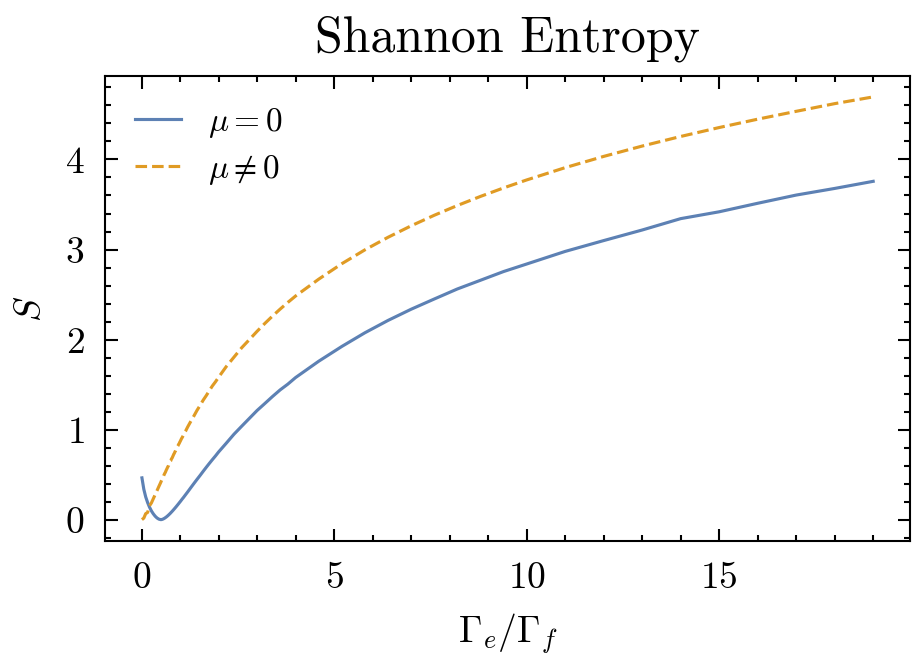

In [93]:

plt.plot(df_Ent['Gamma_e'],df_Ent['Shannon'],label = r'$\mu = 0$')
plt.plot(df_Ent_Mu['Gamma_e'],df_Ent_Mu['Shannon'],label = r'$\mu\neq 0$')
plt.xlabel(r'$\Gamma_e/\Gamma_f$')
plt.ylabel(r'$S$')
plt.title('Shannon Entropy')
plt.legend()

# plt.savefig('Shannon_entropy_Gamma.png')

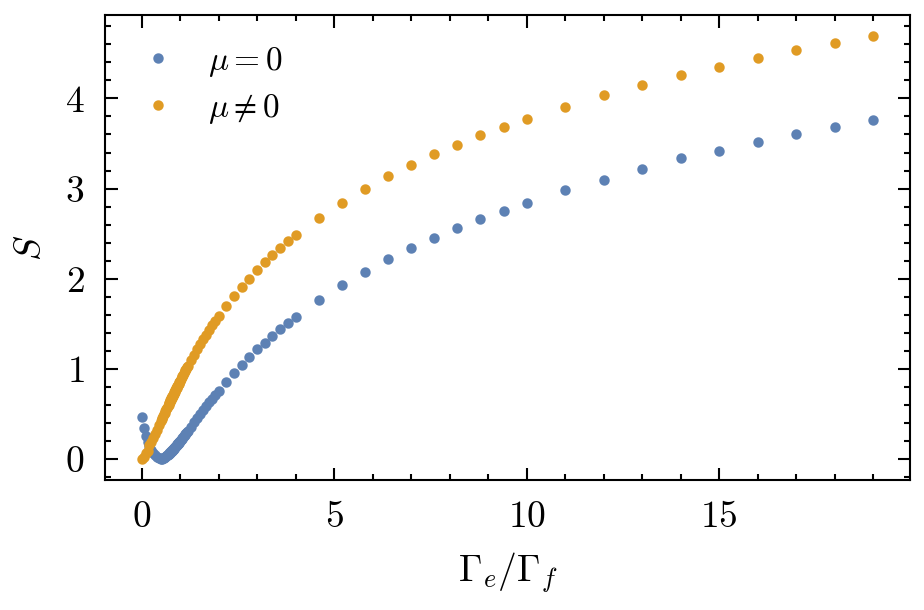

In [237]:

plt.plot(df_Ent['Gamma_e'],df_Ent['Shannon'],'.' ,label = r'$\mu = 0$')
plt.plot(df_Ent_Mu['Gamma_e'],df_Ent_Mu['Shannon'],'.' ,label = r'$\mu\neq 0$')
plt.xlabel(r'$\Gamma_e/\Gamma_f$')
plt.ylabel(r'$S$')
# plt.title('Shannon Entopy')
plt.legend()

plt.savefig('Shannon_entropy.png')

### Uncorrelated

In [14]:
# New_row = {'P_max': 0.38930312, 
#           'Omega_1': 0.007641385216,
#           'Omega_2': 1.46018999,
#           'Gamma_e': 0.01}
# # df_Uncor.loc[len(df_Uncor)] = New_row
# df_Uncor = df_Uncor.sort_values(by='Gamma_e').reset_index(drop=True)
# df_Uncor.to_csv('dataSet/paper/P_Gaussian_Uncor.csv',index_label=False)

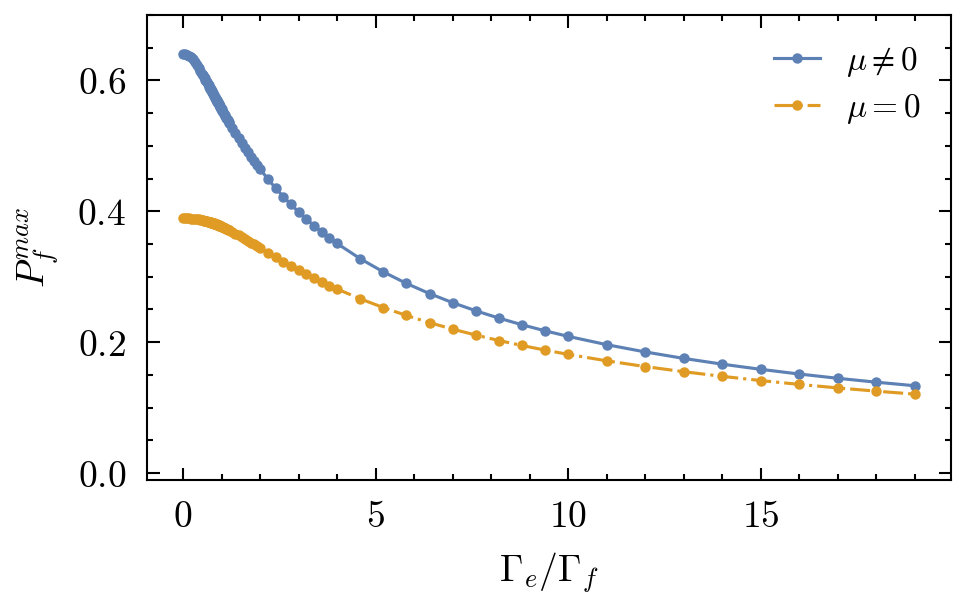

In [15]:
df_Uncor = pd.read_csv('dataSet/paper/P_Gaussian_Uncor.csv')
df_Uncor.reset_index(inplace=True,drop=True)
df_Uncor_Mu = pd.read_csv('dataSet/paper/P_Gaussian_Uncor_Mu.csv')
df_Uncor_Mu.reset_index(inplace=True,drop=True)

plt.plot(df_Uncor_Mu['Gamma_e'][:-3], df_Uncor_Mu['P_max'][:-3],'.-',label = r'$\mu \neq 0$')
plt.plot(df_Uncor['Gamma_e'][:-3], df_Uncor['P_max'][:-3],'.-.',label = r'$\mu = 0$')

plt.xlabel(r'$\Gamma_e/\Gamma_f$')
plt.ylabel(r'$P_f^{max}$')
plt.ylim(-0.01,0.7)
# plt.title('Uncorrelated')
plt.legend(frameon=False)
# plt.savefig('Uncorrelated_GammaRatio.eps')

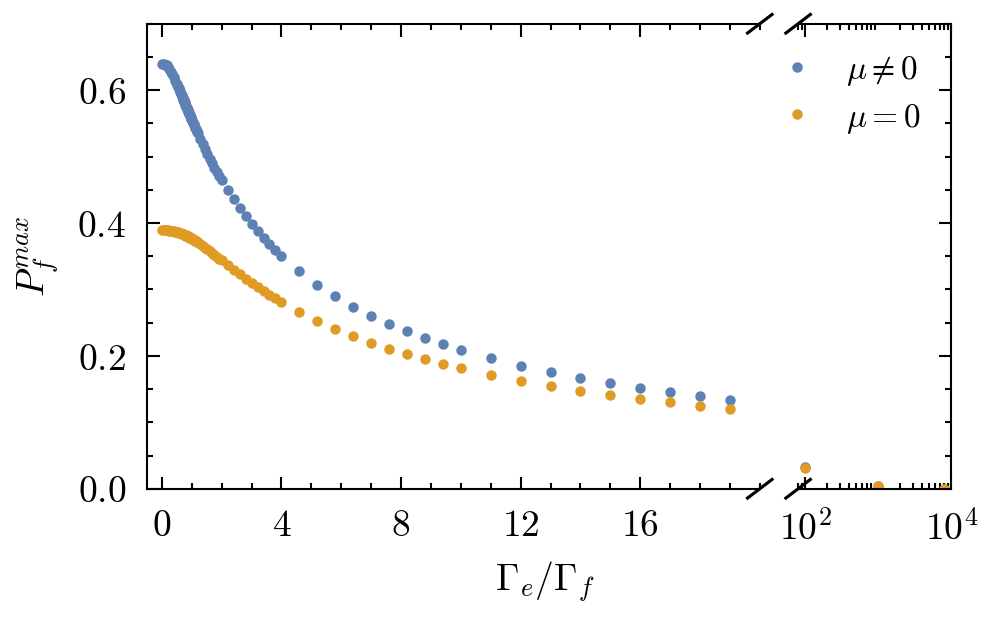

In [16]:


fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w', gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.1})

# Plot the first range (0 to 10)
ax.plot(df_Uncor_Mu['Gamma_e'], df_Uncor_Mu['P_max'],'.',label = r'$\mu \neq 0$')
ax.plot(df_Uncor['Gamma_e'], df_Uncor['P_max'],'.',label = r'$\mu = 0$')
ax.set_xlim(-0.5, 20)
ax.set_xticks(np.arange(0, 20, 4))
ax.set_ylim(0,0.7)
ax.spines['right'].set_visible(False)
ax.yaxis.tick_left()
ax.set_xlabel(r'$\Gamma_e/\Gamma_f$')
ax.xaxis.set_label_coords(0.65,-0.15)

ax.set_ylabel(r'$P_f^{max}$')
# ax.grid(True)

# Plot the second range (100 and 1000)
ax2.semilogx(df_Uncor_Mu['Gamma_e'], df_Uncor_Mu['P_max'],'.',label = r'$\mu \neq 0$')
ax2.semilogx(df_Uncor['Gamma_e'], df_Uncor['P_max'],'.',label = r'$\mu = 0$')
ax2.set_xlim(80, 8000)
ax2.set_xticks([100,10000])
ax2.spines['left'].set_visible(False)
ax2.yaxis.tick_right()

# ax2.grid(True)




d = .02  # size of the break markers
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, linestyle = 'solid')
ax.plot((1-d, 1+d), (-d, +d), **kwargs)
ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-4*d, +4*d), (-d, +d), **kwargs)
ax2.plot((-4*d, +4*d), (1-d, 1+d), **kwargs)
ax2.legend(loc='upper right')
# Add some space between the subplots for better visual separation
plt.savefig('Uncorrelated_Gaussian.png',dpi = 300)
plt.show()


### $\mu \neq 0$

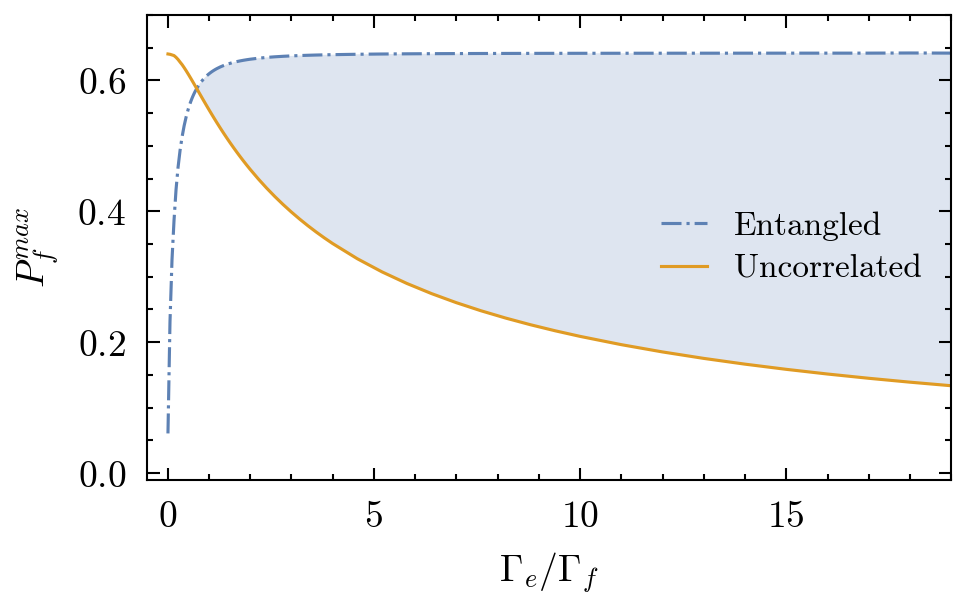

In [17]:
plt.plot(df_Ent_Mu['Gamma_e'][:-3], df_Ent_Mu['P_max'][:-3],'-.',label = 'Entangled')
plt.plot(df_Uncor_Mu['Gamma_e'][:-3], df_Uncor_Mu['P_max'][:-3],'-',label = 'Uncorrelated')

indx = df_Ent_Mu.iloc[1:].reset_index(drop=True)
indx =  indx[indx['P_max'] > df_Uncor_Mu['P_max']].index
plt.fill_between(df_Ent_Mu['Gamma_e'][indx+1] , df_Ent_Mu['P_max'][indx+1],df_Uncor_Mu['P_max'][indx],alpha = 0.2 )
plt.xlabel(r'$\Gamma_e/\Gamma_f$')
plt.ylabel(r'$P_f^{max}$')
plt.ylim(-0.01,0.7)
plt.xlim(-0.5,19)
# plt.title(r'$\mu \neq 0$')
plt.legend(frameon=False)
# plt.savefig('Gamma_with_MU.png')

In [25]:
df_Ent
df_Uncor

,P_max,Omega_1,Omega_2,Gamma_e
0,0.389303,0.007641,1.460190,0.010
1,0.389149,0.045057,1.495286,0.059
2,0.389096,0.082637,1.434470,0.108
3,0.389035,0.119975,1.471126,0.157
4,0.388837,0.157619,1.456418,0.206
...,...,...,...,...
98,0.125310,5.934624,6.163840,18.000
99,0.120756,6.126477,6.341457,19.000
100,0.031921,15.043690,15.000548,100.000
101,0.003751,136.679236,137.279719,1000.000


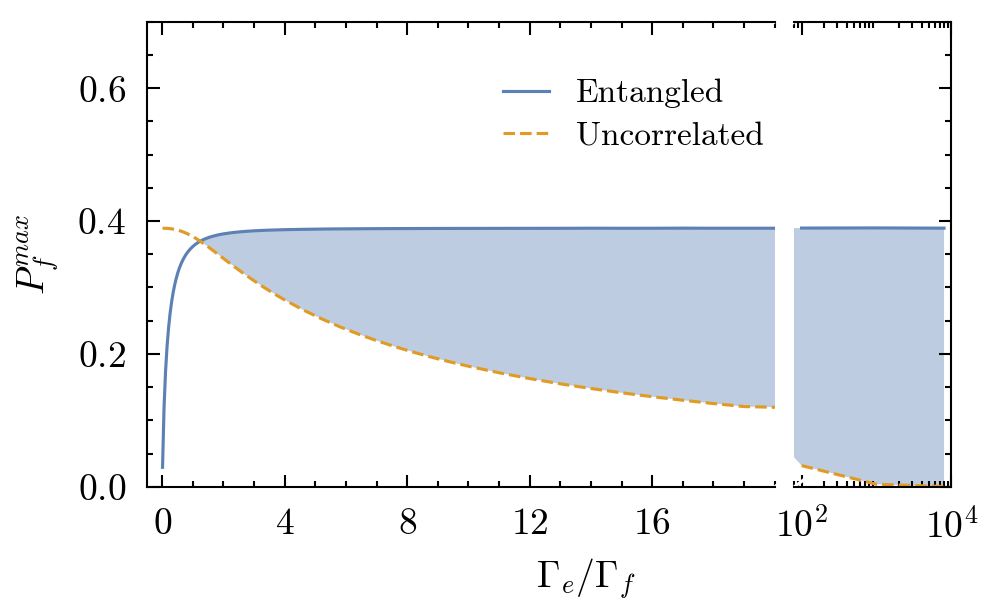

In [28]:
# indx = df_Ent.iloc[:].reset_index(drop=True)
indx = df_Ent
indx =  indx[indx['P_max'] > df_Uncor['P_max']].index


fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w', gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.05})
# fig.patch.set_alpha(0)
# ax.patch.set_alpha(0.05)
# ax2.patch.set_alpha(0.05)


# Plot the first range (0 to 10)
ax.plot(df_Ent['Gamma_e'], df_Ent['P_max'],label = r'Entangled')  #,color = '#FFA500')
ax.plot(df_Uncor['Gamma_e'], df_Uncor['P_max'],label = r'Uncorrelated')  #, color = '#FFFF00')
# ax.fill_between(df_Ent_Mu['Gamma_e'][indx+1] , df_Ent_Mu['P_max'][indx+1],df_Uncor_Mu['P_max'][indx],alpha = 0.8, color = '#F9E8C9' )
ax.fill_between(df_Ent['Gamma_e'][indx] , df_Ent['P_max'][indx],df_Uncor['P_max'][indx],alpha = 0.4)  #, color = '#00FFFF' )
ax.set_xlim(-0.5, 20)
ax.set_xticks(np.arange(0, 20, 4))
ax.set_ylim(0,0.7)
ax.spines['right'].set_visible(False)
ax.yaxis.tick_left()
ax.set_xlabel(r'$\Gamma_e/\Gamma_f$')
ax.xaxis.set_label_coords(0.7,-0.15)
ax.set_ylabel(r'$P_f^{max}$')
# ax.spines['top'].set_color('white')
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_color('white')
# ax.grid(True)
# ax.tick_params(axis='x',  which='both', colors='white')
# ax.tick_params(axis='y',  which='both', colors='white')

# Change the color of the axis labels
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')

# Plot the second range (100 and 1000)
ax2.semilogx(df_Ent['Gamma_e'][-3:], df_Ent['P_max'][-3:],label = r'Entangled')  #,color = '#FFA500')
ax2.semilogx(df_Uncor['Gamma_e'][-3:], df_Uncor['P_max'][-3:],label = r'Uncorrelated')  #, color = '#FFFF00')
ax2.fill_between(df_Ent['Gamma_e'][indx] , df_Ent['P_max'][indx],df_Uncor['P_max'][indx],alpha = 0.4)  #, color = '#00FFFF' )
ax2.set_xlim(80, 8000)
ax2.set_xticks([100,10000])
ax2.spines['left'].set_visible(False)
ax2.yaxis.tick_right()
# ax2.spines['top'].set_color('white')
# ax2.spines['bottom'].set_color('white')
# ax2.spines['right'].set_color('white')
# ax2.tick_params(axis='x', which='both', colors='white')
# ax2.tick_params(axis='y', which='both', colors='white')

# Change the color of the axis labels
# ax2.xaxis.label.set_color('white')
# ax2.yaxis.label.set_color('white')


# ax2.grid(True)



# Set the axes background to transparent


d = .015  # size of the break markers
kwargs = dict(transform=ax.transAxes, color='#FFFFFF', clip_on=False, linestyle = 'solid')
ax.plot((1-d, 1+d), (-d, +d), **kwargs)
ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-4*d, +4*d), (-d, +d), **kwargs)
ax2.plot((-4*d, +4*d), (1-d, 1+d), **kwargs)
ax.legend(loc='right',frameon=False,bbox_to_anchor=(1.03, 0.8))
# Add some space between the subplots for better visual separation
plt.savefig('Entangled_Unentangled_withoutMU.png',dpi = 300)
plt.show()


### $\mu = 0$

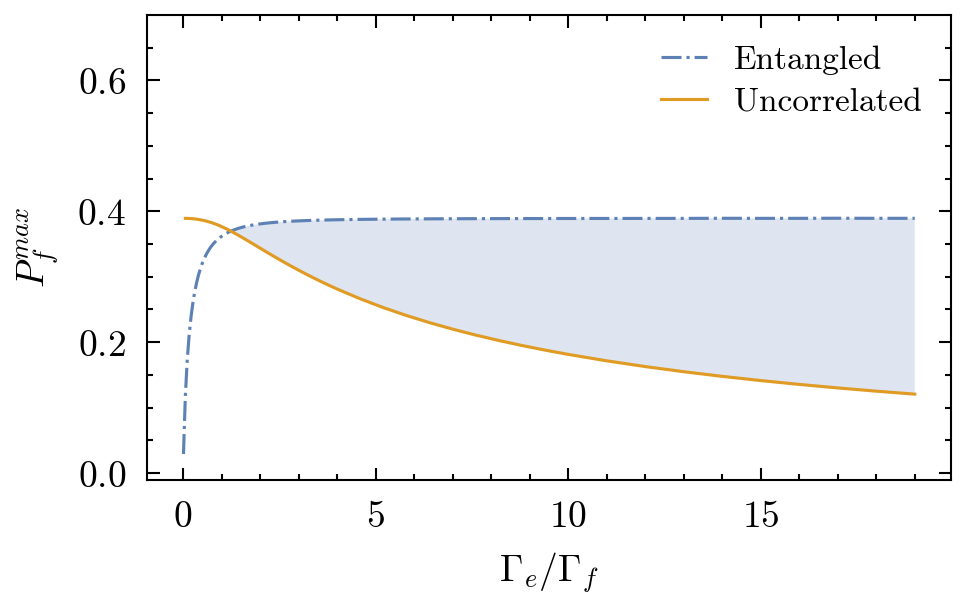

In [267]:
plt.plot(df_Ent['Gamma_e'], df_Ent['P_max'],'-.',label = 'Entangled')
plt.plot(df_Uncor['Gamma_e'], df_Uncor['P_max'],'-',label = 'Uncorrelated')

indx = df_Ent.iloc[1:].reset_index(drop=True)
indx =  indx[indx['P_max'] > df_Uncor['P_max']].index
plt.fill_between(df_Ent['Gamma_e'][indx+1] , df_Ent['P_max'][indx+1],df_Uncor['P_max'][indx],alpha = 0.2 )
plt.xlabel(r'$\Gamma_e/\Gamma_f$')
plt.ylabel(r'$P_f^{max}$')
plt.ylim(-0.01,0.7)
# plt.title(r'$\mu = 0$')
plt.legend(frameon=False)
plt.savefig('Gamma_Without_Mu.png')

## Fig.1 of paper

In [316]:
df_expoDecay = pd.read_csv('dataSet/paper/P_Gamma_Uncorrelated_ExpoDecay.csv')
df_expoDecay[:20]

,P_max,Omega_1,Omega_2,Gamma_e
0,0.010787,0.206655,0.082965,0.010000
1,0.019933,0.250023,0.101114,0.019667
2,0.028213,0.283066,0.115185,0.029333
3,0.035810,0.319271,0.130437,0.039000
4,0.042833,0.345016,0.141608,0.048667
5,0.049367,0.366887,0.151267,0.058333
6,0.055476,0.382422,0.158458,0.068000
7,0.061205,0.405456,0.168545,0.077667
8,0.066597,0.419765,0.175248,0.087333
9,0.071685,0.435379,0.182449,0.097000


(0.0, 9.5)

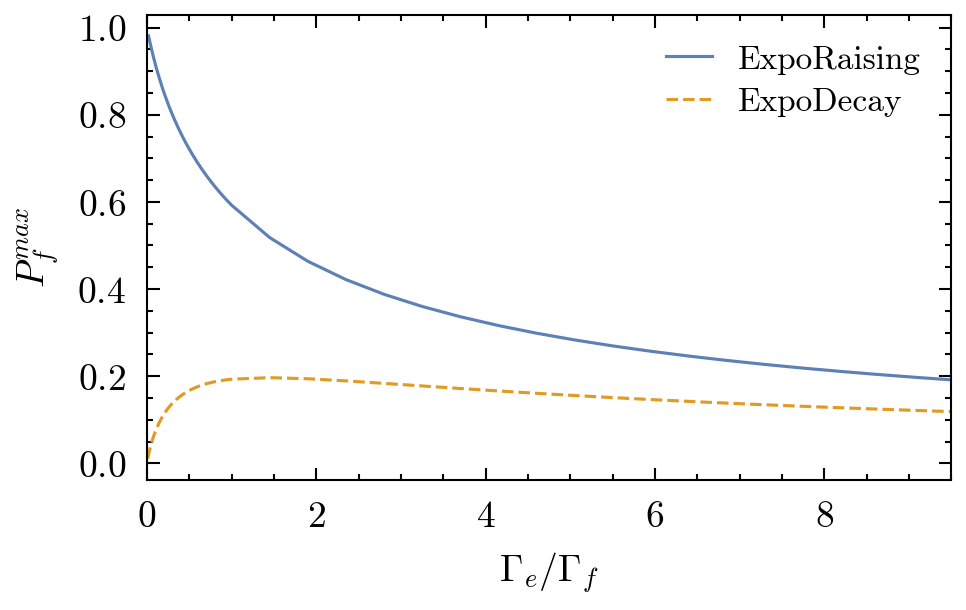

In [315]:
def expo_raising(x):
    numerator = 64*x*(np.sqrt(1+8*x) -1)
    denominator = (4*x + np.sqrt(1 + 8*x) - 1)**2*(3 + np.sqrt(1 + 8*x))
    return numerator/denominator

plt.plot(GAMMA_F, expo_raising(GAMMA_F), label = 'ExpoRaising')
expo_decay = pd.read_csv('dataSet/paper/P_Gamma_Uncorrelated_ExpoDecay.csv')
plt.plot(expo_decay['Gamma_e'], expo_decay['P_max'], label = 'ExpoDecay')

plt.xlabel(r'$\Gamma_e/\Gamma_f$')
plt.ylabel(r'$P_f^{max}$')
plt.legend(frameon=False)
plt.xlim(0,9.5)
# plt.savefig('dataSet/paper/Raising_Deacying.eps')

## Coherent Case:

In [253]:
data_ExpoDecay = pd.read_csv('dataSet/paper/P_Coherent_ExpoDecay.csv')
data_ExpoRaising = pd.read_csv('dataSet/paper/P_Coherent_ExpoRaising.csv')
data_Gaussian = pd.read_csv('dataSet/paper/P_Coherent_Gaussian.csv')
data_Gaussian_Mu = pd.read_csv('dataSet/paper/P_Coherent_Gaussian_Mu.csv')
data_Gaussian_Mu_n2 = pd.read_csv('dataSet/paper/P_Coherent_Gaussian_n2.csv')



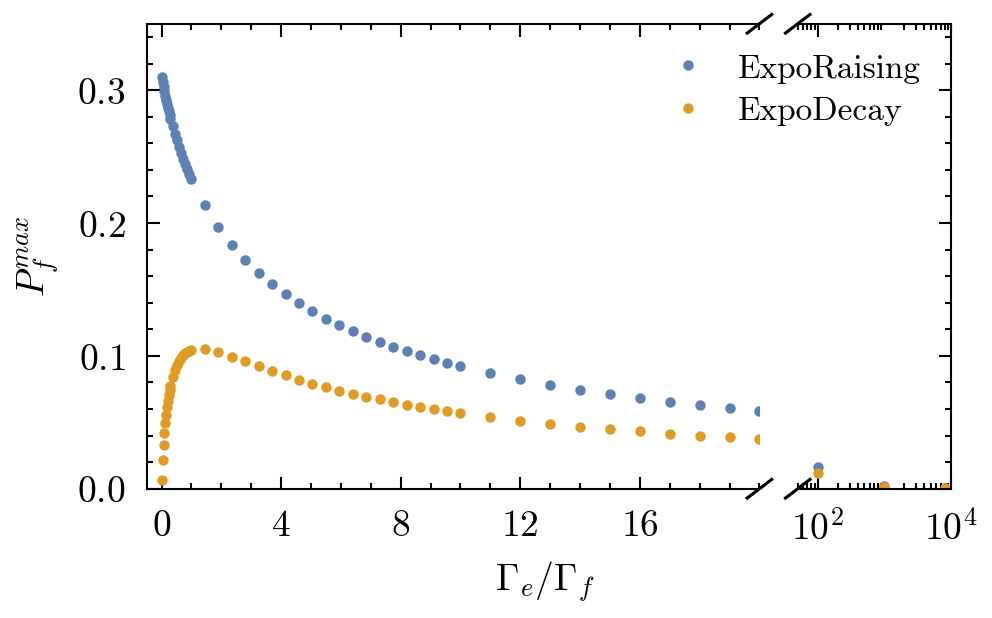

In [255]:

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w', gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.1})

# Plot the first range (0 to 20)
ax.plot(data_ExpoRaising['Gamma_e'][:-3], data_ExpoRaising['P_max'][:-3],'.',label = r'ExpoRaising')
ax.plot(data_ExpoDecay['Gamma_e'][:-3], data_ExpoDecay['P_max'][:-3],'.',label = r'ExpoDecay')
ax.set_xlim(-0.5, 20)
ax.set_xticks(np.arange(0, 20, 4))
ax.set_ylim(0,0.35)
ax.spines['right'].set_visible(False)
ax.yaxis.tick_left()
ax.set_xlabel(r'$\Gamma_e/\Gamma_f$')
ax.xaxis.set_label_coords(0.65,-0.15)
ax.set_ylabel(r'$P_f^{max}$')
# ax.grid(True)

# Plot the second range (100 and 10000)
ax2.semilogx(data_ExpoRaising['Gamma_e'][-3:], data_ExpoRaising['P_max'][-3:],'.',label = r'ExpoRaising')
ax2.semilogx(data_ExpoDecay['Gamma_e'][-3:], data_ExpoDecay['P_max'][-3:],'.',label = r'ExpoDecay')
ax2.set_xlim(50, 10000)
ax2.set_xticks([100,10000])
ax2.spines['left'].set_visible(False)
ax2.yaxis.tick_right()

# ax2.grid(True)




d = .02  # size of the break markers
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, linestyle = 'solid')
ax.plot((1-d, 1+d), (-d, +d), **kwargs)
ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-4*d, +4*d), (-d, +d), **kwargs)
ax2.plot((-4*d, +4*d), (1-d, 1+d), **kwargs)
ax2.legend(loc='upper right')
# Add some space between the subplots for better visual separation
# plt.savefig('Coherent_Exponential.png',dpi = 300)
plt.show()


In [93]:
# plt.plot(data_Gaussian['Gamma_e'][:-3],data_Gaussian['P_max'][:-3], '.',label=r'$\mu = 0$')
# plt.plot(data_Gaussian_Mu['Gamma_e'][:-3],data_Gaussian_Mu['P_max'][:-3], '.',label=r'$\mu \neq 0$')
# plt.xlabel(r'$\Gamma_e/\Gamma_f$')
# plt.ylabel(r'$P_f^{max}$')
# plt.ylim(-0.01,0.3)
# plt.title('Gaussian')
# plt.legend()
# plt.savefig('Coherent_Gauss.png')

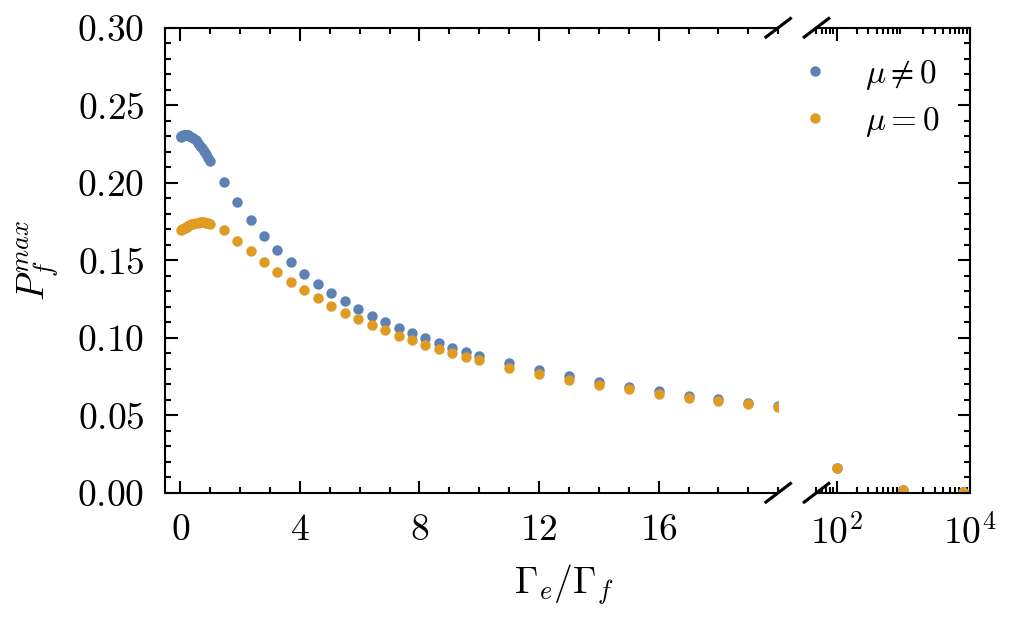

In [256]:
import matplotlib.pyplot as plt
import numpy as np

x2 = [100, 1000, 8000]              # x at 100 and 1000
P_withMu = [0.641704767, 0.64141003027, 0.64148]              # Replace with your actual data
P_withoutMu = [0.38944, 0.3896677609, 0.389303]              # Replace with your actual data

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w', gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.1})

# Plot the first range (0 to 10)
ax.plot(data_Gaussian_Mu['Gamma_e'][:-3],data_Gaussian_Mu['P_max'][:-3], '.',label=r'$\mu \neq 0$')
ax.plot(data_Gaussian['Gamma_e'][:-3],data_Gaussian['P_max'][:-3], '.',label=r'$\mu = 0$')
ax.set_xlim(-0.5, 20)
ax.set_xticks(np.arange(0, 20, 4))
ax.set_ylim(0,0.3)
ax.spines['right'].set_visible(False)
ax.yaxis.tick_left()
ax.set_xlabel(r'$\Gamma_e/\Gamma_f$')
ax.xaxis.set_label_coords(0.65,-0.15)
ax.set_ylabel(r'$P_f^{max}$')
# ax.grid(True)

# Plot the second range (100 and 1000)
ax2.semilogx(data_Gaussian_Mu['Gamma_e'][-3:],data_Gaussian_Mu['P_max'][-3:], '.',label=r'$\mu \neq 0$')
ax2.semilogx(data_Gaussian['Gamma_e'][-3:],data_Gaussian['P_max'][-3:], '.',label=r'$\mu = 0$')
ax2.set_xlim(50, 10000)
ax2.set_xticks([100,10000])
ax2.spines['left'].set_visible(False)
ax2.yaxis.tick_right()

# ax2.grid(True)




d = .02  # size of the break markers
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, linestyle = 'solid')
ax.plot((1-d, 1+d), (-d, +d), **kwargs)
ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-4*d, +4*d), (-d, +d), **kwargs)
ax2.plot((-4*d, +4*d), (1-d, 1+d), **kwargs)
ax2.legend(loc='upper right')
# Add some space between the subplots for better visual separation
plt.savefig('Coherent_Gaussian.png',dpi = 300)
plt.show()


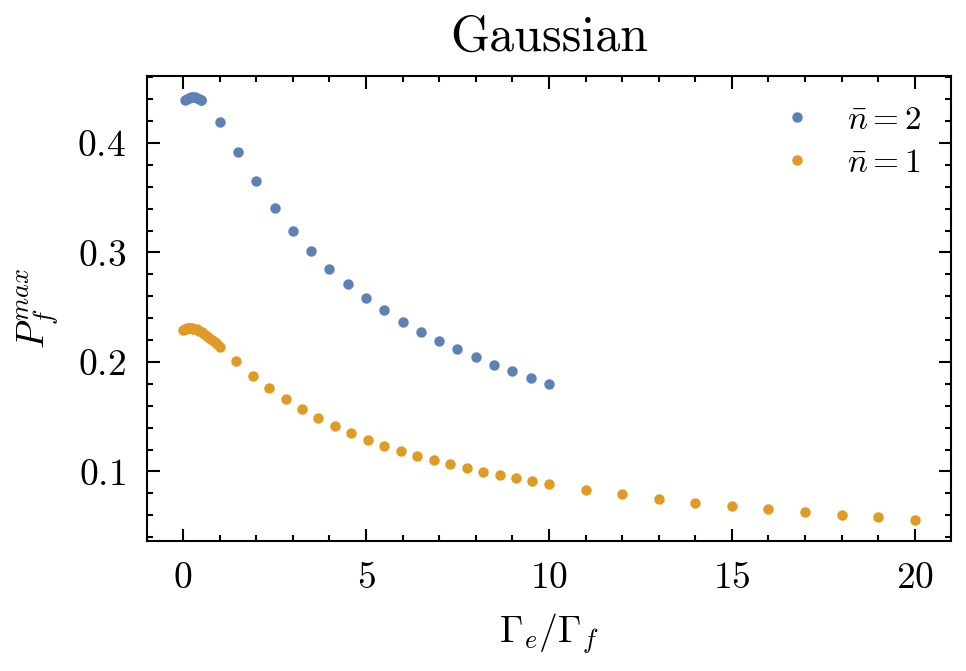

In [146]:
plt.plot(data_Gaussian_Mu_n2['Gamma_e'][1:],data_Gaussian_Mu_n2['P_max'][1:], '.',label=r'$\bar n = 2$')
plt.plot(data_Gaussian_Mu['Gamma_e'],data_Gaussian_Mu['P_max'], '.',label=r'$\bar n = 1$')
plt.xlabel(r'$\Gamma_e/\Gamma_f$')
plt.ylabel(r'$P_f^{max}$')
# plt.ylim(-0.01,0.3)
plt.title('Gaussian')
plt.legend()
# plt.savefig('Coherent_Gaussian_nCompare.png')

In [95]:
# import warnings

# # Ignore all warnings
# warnings.filterwarnings("ignore")
# t0 = time()
# g1 = 0.01
# s1 = 1
# g2 = 1
# s2 = 1
# Delta_1 = 0
# Delta_2 = -Delta_1
# nBins = 1000
# n = 1
# Experiment = L3.TwoPhoton(Gaussian, Gamma_1= g1, Omega_1= s1,
#                               Gamma_2= g2, Omega_2= s2, Delta_1 = Delta_1, Delta_2 = Delta_2,
#                               n_1 = n, n_2 = n, nBins = nBins, status = 'Coherent' )
# @timer
# def opt(Experiment):
#     return Experiment.optimize(parameters_to_optimize=['Omega_1' , 'Omega_2'],Param_range = [0.001,2],num_attempts = 200,num_processor = 20)
# a = []
# for i in range (1):
#     res = opt(Experiment)
#     res['$G_e/G_f$'] = g1
#     a.append(res)

# df = pd.DataFrame(a)
# df  

In [94]:
# warnings.filterwarnings("ignore")
# @timer
# def opt(Experiment):
#     return Experiment.optimize(parameters_to_optimize=['Omega_1' , 'Omega_2'],Param_range = [0.001,7],num_attempts = 200,num_processor = 20)


# GAMMA_F = np.linspace(0.01,0.3,10, endpoint=False)
# GAMMA_F = np.append(GAMMA_F, np.linspace(0.3,1,10, endpoint=False))
# GAMMA_F = np.append(GAMMA_F, np.linspace(1,10,20, endpoint=False))

# g1 = 1
# g2 = 1
# s1 = 1
# s2 = 1
# Mu = 0
# Delta_1 = 0
# Delta_2 = -Delta_1
# nBins = 1000
# nBar = 1
# pulseShape = Gaussian  # The wave shape
# p_opt = []
# t0 = time()

# parameters_to_optimize = ['Omega_1','Omega_2']
# counter = 0
# for g1 in GAMMA_F:
#     Experiment = L3.TwoPhoton(pulseShape, Gamma_1= g1, Omega_1= s1,
#                           Gamma_2= g2, Omega_2= s2, Delta_1 = Delta_1, Delta_2 = Delta_2,
#                           n_1 = nBar, n_2 = nBar, nBins = nBins,  status = 'Coherent' )
#     try:
#        # res = Experiment.optimize(parameters_to_optimize = parameters_to_optimize , Param_range = [0.001,10], num_attempts = 200,num_processor = 20)
#        print(counter)
#        counter += 1 
#        res = opt(Experiment)
#        res ['Gamma_e'] = g1
#        p_opt.append(res)
#     except:
#        print('something happend!',g1)

# print(f'The total time for {pulseShape.__name__} coherent state : {time() - t0}')
# p_opt = pd.DataFrame(p_opt)
# p_opt.to_csv('P_Gamma_coherent_'+pulseShape.__name__+'.csv',index_label=False)


## HeatMap of optimum

### Gaussian

This plot is for the Gaussian pulse with following specifications:
1.0303360780276396, 10.425280342877375


For Entangled Gaussian

| $\Gamma_e$ | $\Gamma_f$ | $\Omega_+$ | $\Omega_-$ |    $\mu$    |  $P_{max}$  |
|------------|------------|------------|------------|-------------|-------------|
| 0.5        | 1          | 0.78826     | 1.38264   | 1.618855    | 0.555524    |
| 1          | 1          | 0.9185     | 2.3377     |  0.915395   | 0.6095      |
| 5          | 1          | 1.0304     | 10.425     |  0.198731   |             |
| 20         | 1          | 1.054440205| 41.425497  |  0.04992066 | 0.04992066  |



In [245]:
def psi_w(w1,w2,**kwargs):
    OmegaP = kwargs.get('OmegaP', 1)
    OmegaM = kwargs.get('OmegaM', 1)
    Mu = kwargs.get('Mu', 0)
    w_01 = kwargs.get('w_01', 0)
    w_02 = kwargs.get('w_02', 0)
    w1_len = len(w1)
    w2_len = len(w2)
    w1, w2 = np.meshgrid(w1, w2)
    N = 1/np.sqrt(np.pi*OmegaP*OmegaM/2)
    psi = N*np.exp( -(w1+w2 - w_01-w_02)**2/(2*OmegaP**2) - (w2 -w1 -(w_02 - w_01) )**2/(2*OmegaM**2) + 1j*(w2 - w_02)*Mu )
    psi = np.abs(psi)**2
    return psi.reshape(w1_len,w2_len)
def psi_t(t1,t2,**kwargs):
    OmegaP = kwargs.get('OmegaP', 1)
    OmegaM = kwargs.get('OmegaM', 1)
    Mu = kwargs.get('Mu', 0)
    t1, t2 = np.meshgrid(t1, t2)
    N = np.sqrt(OmegaP*OmegaM/(np.pi*2))
    psi = N*np.exp( -(t2- Mu + t1 )**2*(OmegaP**2/8) - (t2 - Mu -t1 )**2*(OmegaM**2/8) )
    psi = np.abs(psi)**2
    return psi.reshape(len(t1),len(t2))


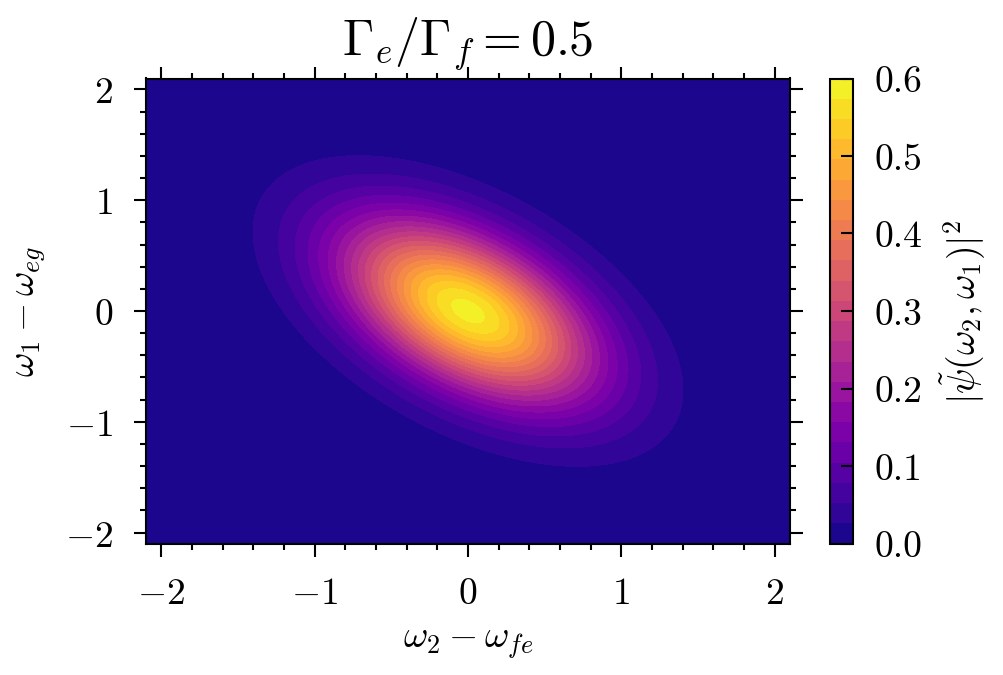

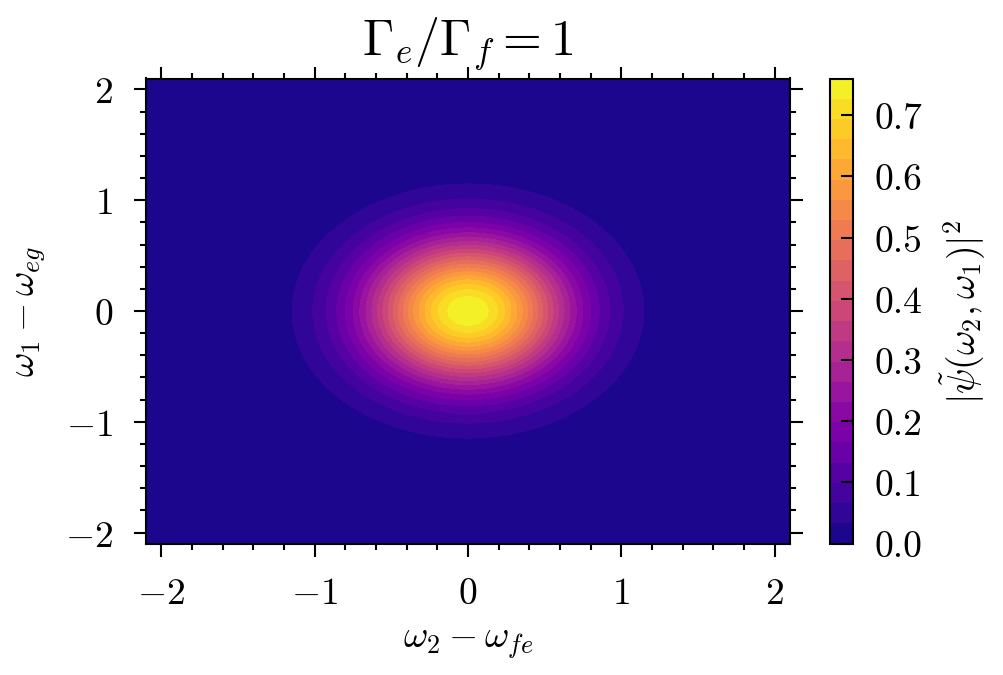

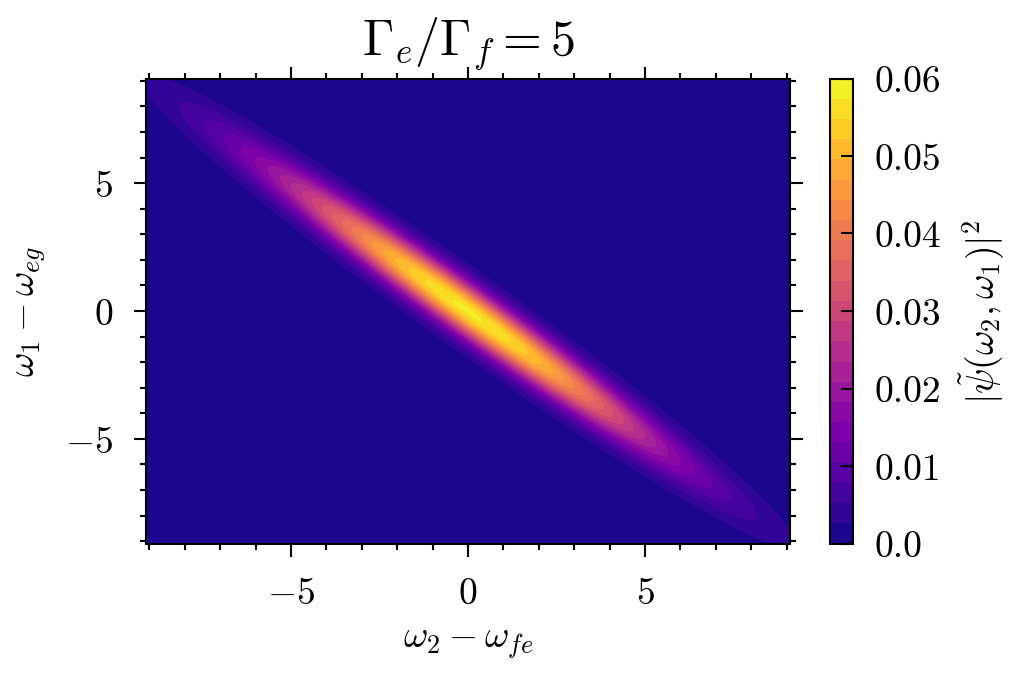

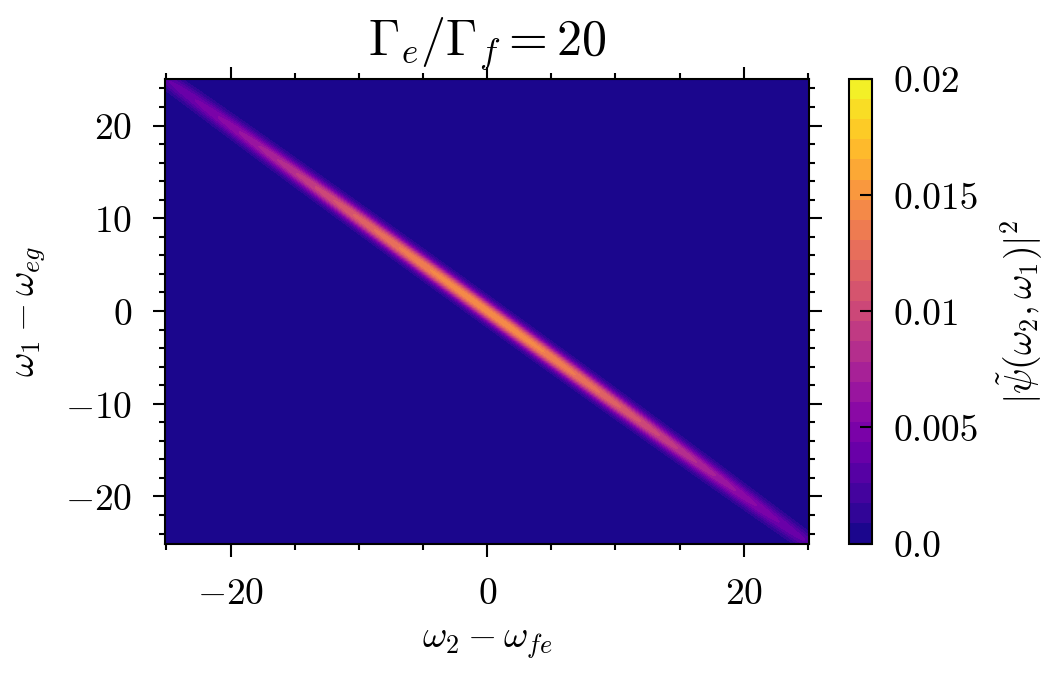

In [246]:
#############################3# Gamma_e = 0.5  ##########################################

w1 = np.linspace(-2.1,2.1,1000)
w2 = np.linspace(-2.1,2.1,1000)
# w2 = w1
OmegaP, OmegaM = 0.78826, 1.38264

Mu = 1.618855

w_01 = 0
w_02 = 0
PSI = psi_w(w1, w2, OmegaP = OmegaP, OmegaM = OmegaM, w_01 = w_01, w_02 = w_02, Mu = Mu)
# print(PSI.shape)
PSI = plt.contourf(PSI, origin = 'lower',levels=np.linspace(0, 0.6, 24), extent=[w1.min(), w1.max(), w2.min(), w2.max()], aspect='auto', cmap='plasma')
plt.ylabel(r'$\omega_1 - \omega_{eg}$')
plt.xlabel(r'$\omega_2 - \omega_{fe}$')
cbar = plt.colorbar(PSI)
cbar.set_ticks(np.arange(0,0.61,0.1))
cbar.set_ticklabels(np.round(np.arange(0,0.61,0.1),2))
plt.tick_params(axis='both', which = 'both', direction = 'out')
cbar.set_label(r'$|\tilde{\psi}(\omega_2,\omega_1)|^2$')
plt.title(r'$\Gamma_e/\Gamma_f = 0.5$')
plt.savefig('Gaussian_frequency_half.png')
plt.show()


#############################3# Gamma_e = 1  ##########################################

w1 = np.linspace(-2.1,2.1,1000)
w2 = w1
OmegaP, OmegaM = 0.9185, 0.915395

Mu = 0.6095

w_01 = 0
w_02 = 0
PSI = psi_w(w1, w2, OmegaP = OmegaP, OmegaM = OmegaM, w_01 = w_01, w_02 = w_02, Mu = Mu)
PSI = plt.contourf(PSI, origin = 'lower',levels=np.linspace(0, 0.76, 24), extent=[w1.min(), w1.max(), w2.min(), w2.max()], aspect='auto', cmap='plasma')
plt.ylabel(r'$\omega_1 - \omega_{eg}$')
plt.xlabel(r'$\omega_2 - \omega_{fe}$')
cbar = plt.colorbar(PSI)
cbar.set_ticks(np.arange(0,0.76,0.1))
cbar.set_ticklabels(np.round(np.arange(0,0.76,0.1),2))
plt.tick_params(axis='both', which = 'both', direction = 'out')
cbar.set_label(r'$|\tilde{\psi}(\omega_2,\omega_1)|^2$')
plt.title(r'$\Gamma_e/\Gamma_f = 1$')
plt.savefig('Gaussian_frequency_1.png')
plt.show()


#############################3# Gamma_e = 5  ##########################################

w1 = np.linspace(-9.1,9.1,1000)
w2 = w1
OmegaP, OmegaM = 1.05276448624927841, 10.469057374949045

Mu = 0.198731

w_01 = 0
w_02 = 0
PSI = psi_w(w1, w2, OmegaP = OmegaP, OmegaM = OmegaM, w_01 = w_01, w_02 = w_02, Mu = Mu)
PSI = plt.contourf(PSI, origin = 'lower',levels=np.linspace(0, 0.06, 24), extent=[w1.min(), w1.max(), w2.min(), w2.max()], aspect='auto', cmap='plasma')
plt.ylabel(r'$\omega_1 - \omega_{eg}$')
plt.xlabel(r'$\omega_2 - \omega_{fe}$')
cbar = plt.colorbar(PSI)
cbar.set_ticks(np.arange(0,0.061,0.01))
cbar.set_ticklabels(np.round(np.arange(0,0.061,0.01),2))
plt.tick_params(axis='both', which = 'both', direction = 'out')
cbar.set_label(r'$|\tilde{\psi}(\omega_2,\omega_1)|^2$')
plt.title(r'$\Gamma_e/\Gamma_f = 5$')
plt.savefig('Gaussian_frequency_5.png')
plt.show()


#############################3# Gamma_e = 20  ##########################################

w1 = np.linspace(-25.1,25.1,1000)
w2 = w1
OmegaP, OmegaM = 1.054440205, 41.425497

Mu = 0.04992066

w_01 = 0
w_02 = 0
PSI = psi_w(w1, w2, OmegaP = OmegaP, OmegaM = OmegaM, w_01 = w_01, w_02 = w_02, Mu = Mu)
PSI = plt.contourf(PSI, origin = 'lower',levels=np.linspace(0, 0.02, 24), extent=[w1.min(), w1.max(), w2.min(), w2.max()], aspect='auto', cmap='plasma')
plt.ylabel(r'$\omega_1 - \omega_{eg}$')
plt.xlabel(r'$\omega_2 - \omega_{fe}$')
cbar = plt.colorbar(PSI)
cbar.set_ticks(np.arange(0,0.021,0.005))
cbar.set_ticklabels(np.round(np.arange(0,0.021,0.005),3))
plt.tick_params(axis='both', which = 'both', direction = 'out')
cbar.set_label(r'$|\tilde{\psi}(\omega_2,\omega_1)|^2$')
plt.title(r'$\Gamma_e/\Gamma_f = 20$')
plt.savefig('Gaussian_frequency_20.png')
plt.show()

In [174]:
(PSI.collections[0].get_paths()[0].vertices).shape

(7792, 2)

0.17345930471297463


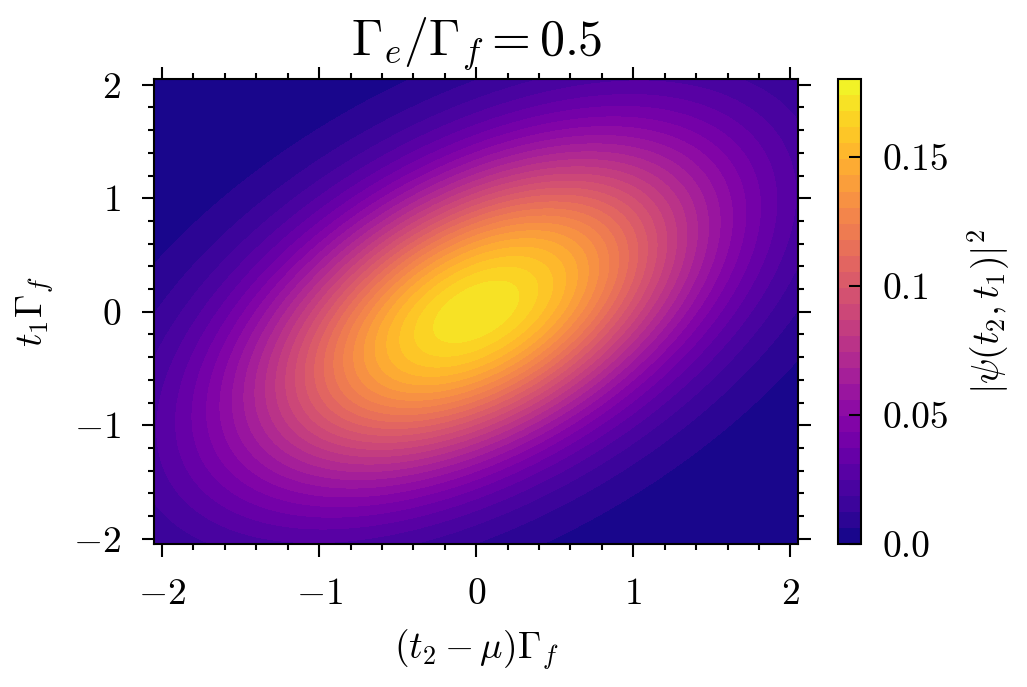

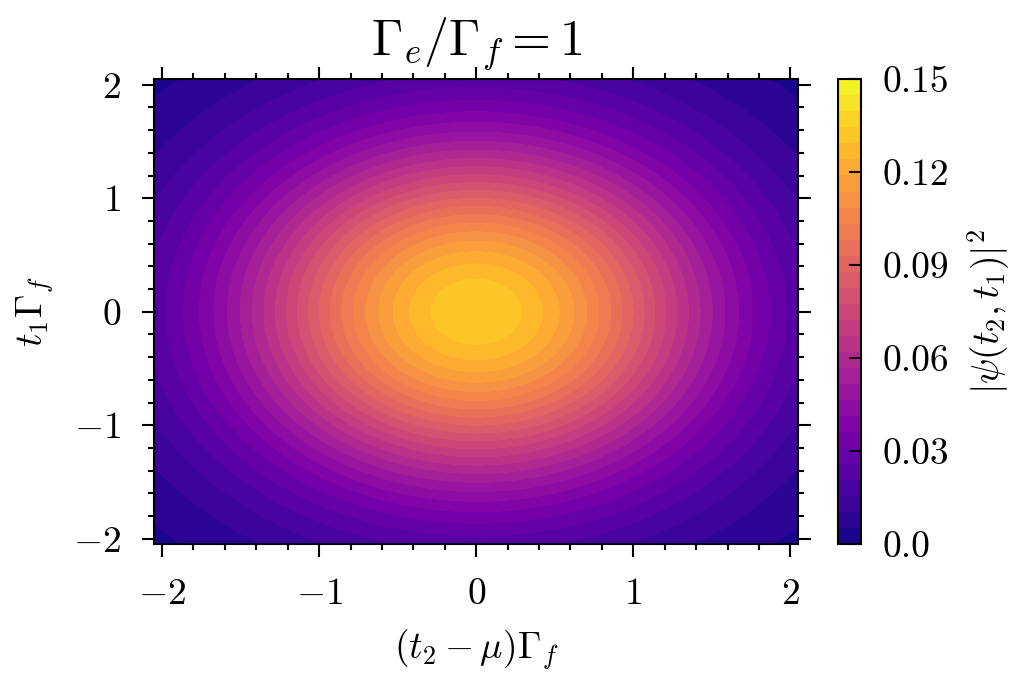

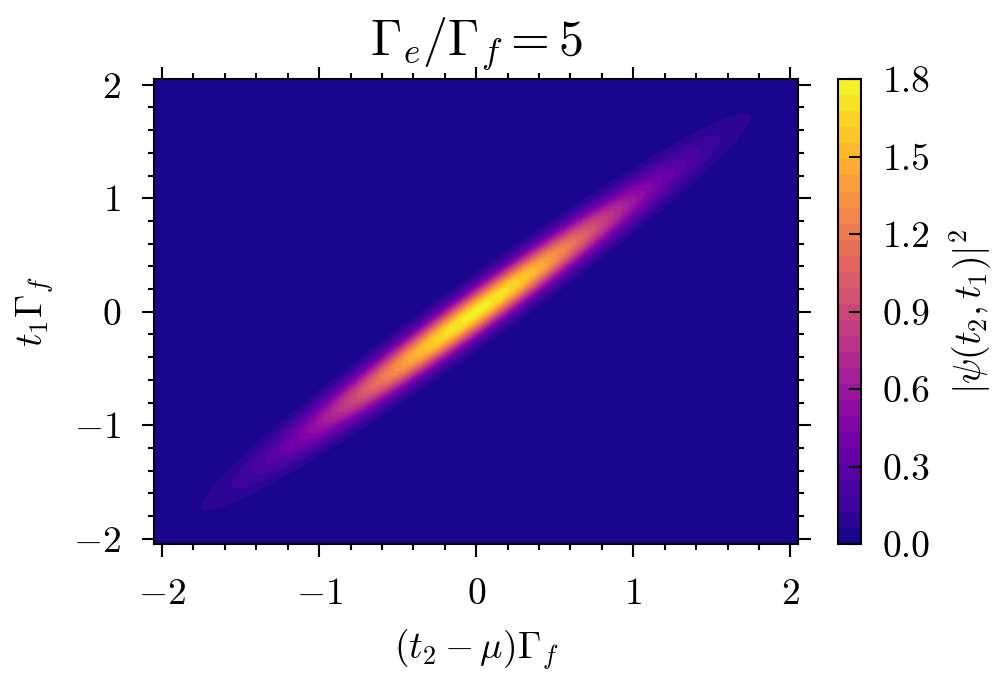

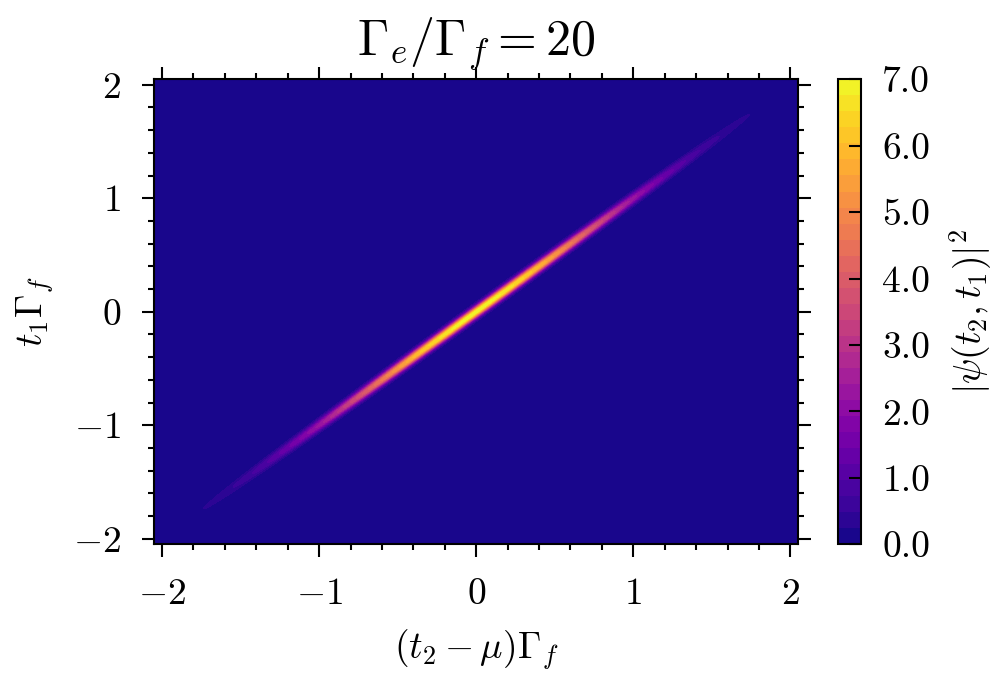

In [247]:
#############################3# Gamma_e = 0.5  ##########################################

t1 = np.linspace(-2.05,2.05,1000)
t2 = t1
OmegaP, OmegaM = 0.78826, 1.38264
Mu = 1.618855
Mu = 0

PSI = psi_t(t1, t2, OmegaP = OmegaP, OmegaM = OmegaM, Mu = Mu)
print(PSI.max())
PSI = plt.contourf(PSI, origin = 'lower', levels=np.linspace(0,0.18, 30), extent=[t1.min(), t1.max(), t2.min(), t2.max()], aspect='auto', cmap='plasma')
plt.ylabel(r'$t_1 \Gamma_f$')
plt.xlabel(r'$(t_2 - \mu)\Gamma_f$')
cbar = plt.colorbar(PSI)
cbar.set_ticks(np.arange(0,.181,0.05))
cbar.set_ticklabels(np.round(np.arange(0,0.181,0.05),2))
# plt.plot([-2.5,2.1],[-2.5+Mu,2.1+Mu],'--')
plt.tick_params(axis='both', which = 'both', direction = 'out')
cbar.set_label(r'$|\psi(t_2,t_1)|^2$')
plt.title(r'$\Gamma_e/\Gamma_f = 0.5$')
plt.savefig('Gaussian_time_half.png')
plt.show()





#############################3# Gamma_e = 1  ##########################################

t1 = np.linspace(-2.05,2.05,1000)
t2 = t1
OmegaP, OmegaM = 0.9185, 0.915395
Mu = 0.6095
Mu = 0



PSI = psi_t(t1, t2, OmegaP = OmegaP, OmegaM = OmegaM, Mu = Mu)
PSI = plt.contourf(PSI, origin = 'lower', levels=np.linspace(0,.15, 30), extent=[t1.min(), t1.max(), t2.min(), t2.max()], aspect='auto', cmap='plasma')
plt.ylabel(r'$t_1 \Gamma_f$')
plt.xlabel(r'$(t_2 - \mu)\Gamma_f$')
cbar = plt.colorbar(PSI)
cbar.set_ticks(np.arange(0,.151,0.03))
cbar.set_ticklabels(np.round(np.arange(0,.151,0.03),2))
# plt.plot([-2.5,2.1],[-2.5+Mu,2.1+Mu],'--')
plt.tick_params(axis='both', which = 'both', direction = 'out')
cbar.set_label(r'$|\psi(t_2,t_1)|^2$')
plt.title(r'$\Gamma_e/\Gamma_f = 1$')
plt.savefig('Gaussian_time_1.png')
plt.show()




#############################3# Gamma_e = 5  ##########################################

t1 = np.linspace(-2.05,2.05,1000)
t2 = t1
OmegaP, OmegaM = 1.05276448624927841, 10.469057374949045
Mu = 0.198731
Mu = 0


PSI = psi_t(t1, t2, OmegaP = OmegaP, OmegaM = OmegaM, Mu = Mu)
PSI = plt.contourf(PSI, origin = 'lower', levels=np.linspace(0,1.8, 30), extent=[t1.min(), t1.max(), t2.min(), t2.max()], aspect='auto', cmap='plasma')
plt.ylabel(r'$t_1 \Gamma_f$')
plt.xlabel(r'$(t_2 - \mu)\Gamma_f$')
cbar = plt.colorbar(PSI)
cbar.set_ticks(np.arange(0,1.81,0.3))
cbar.set_ticklabels(np.round(np.arange(0,1.81,0.3),1))
# plt.plot([-2.5,2.1],[-2.5+Mu,2.1+Mu],'--')
plt.tick_params(axis='both', which = 'both', direction = 'out')
cbar.set_label(r'$|\psi(t_2,t_1)|^2$')
plt.title(r'$\Gamma_e/\Gamma_f = 5$')
plt.savefig('Gaussian_time_5.png')
plt.show()




#############################3# Gamma_e = 20  ##########################################

t1 = np.linspace(-2.05,2.05,1000)
t2 = t1
OmegaP, OmegaM = 1.054440205, 41.425497
Mu = 0.04992066
Mu = 0


PSI = psi_t(t1, t2, OmegaP = OmegaP, OmegaM = OmegaM, Mu = Mu)
PSI = plt.contourf(PSI, origin = 'lower', levels=np.linspace(0,7, 30), extent=[t1.min(), t1.max(), t2.min(), t2.max()], aspect='auto', cmap='plasma')
plt.ylabel(r'$t_1 \Gamma_f$')
plt.xlabel(r'$(t_2 - \mu)\Gamma_f$')
cbar = plt.colorbar(PSI)
cbar.set_ticks(np.arange(0,7.1,1))
cbar.set_ticklabels(np.round(np.arange(0,7.1,1),1))
# plt.plot([-2.5,2.1],[-2.5+Mu,2.1+Mu],'--')
plt.tick_params(axis='both', which = 'both', direction = 'out')
cbar.set_label(r'$|\psi(t_2,t_1)|^2$')
plt.title(r'$\Gamma_e/\Gamma_f = 20$')
plt.savefig('Gaussian_time_20.png')
plt.show()

### Optimum case

In [272]:
def psi_w(w1,w2,**kwargs):
    Gamma_e = kwargs.get('Gamma_e', 1)
    Gamma_f = kwargs.get('Gamma_f', 1)
    Mu = kwargs.get('Mu', 0)
    w_01 = kwargs.get('w_01', 0)
    w_02 = kwargs.get('w_02', 0)
    w_eg = w_01
    w_fg = w_02 + w_01
    t_star = kwargs.get('t_star', 0)

    w1, w2 = np.meshgrid(w1, w2)
    N = np.sqrt(Gamma_e*Gamma_f)/(2*np.pi)
    psi = N*np.exp(1j*(w1+w2-w_fg)*t_star)/( (Gamma_e/2 + 1j*(w1+w_eg))*(Gamma_f/2 + 1j*(w1+w2-w_fg)) )
    psi = np.abs(psi)**2
    return psi.reshape(len(w1),len(w2))
def psi_t(t1,t2,**kwargs):
    Gamma_e = kwargs.get('Gamma_e', 1)
    Gamma_f = kwargs.get('Gamma_f', 1)
    # Mu = kwargs.get('Mu', 0)
    t1, t2 = np.meshgrid(t1, t2)
    
    psi = Gamma_e*Gamma_f*np.exp((Gamma_f - Gamma_e)*t2 + Gamma_e*t1 )
    mask = t2 > t1
    psi[mask] = 0
    return psi.reshape(len(t1),len(t2))


0.8104882579717826


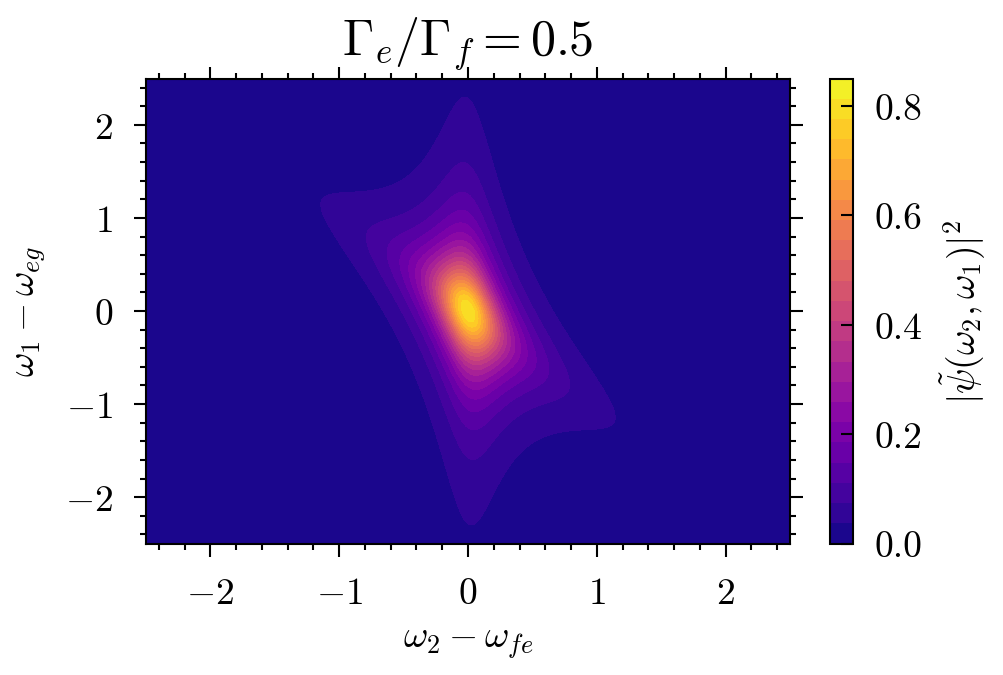

0.4052745824106254


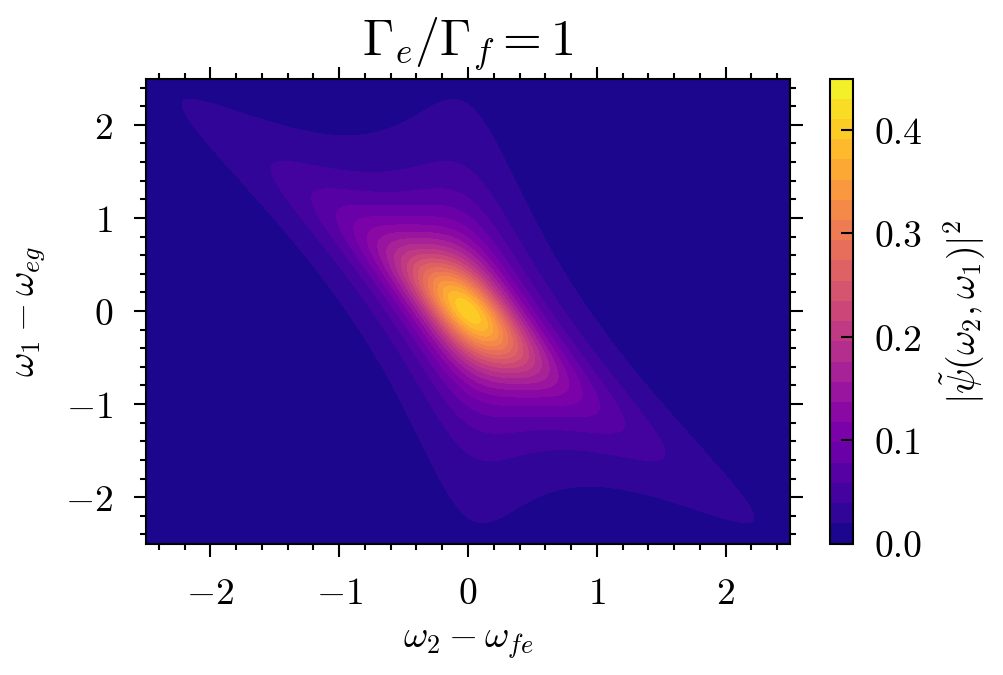

0.08105609431506955


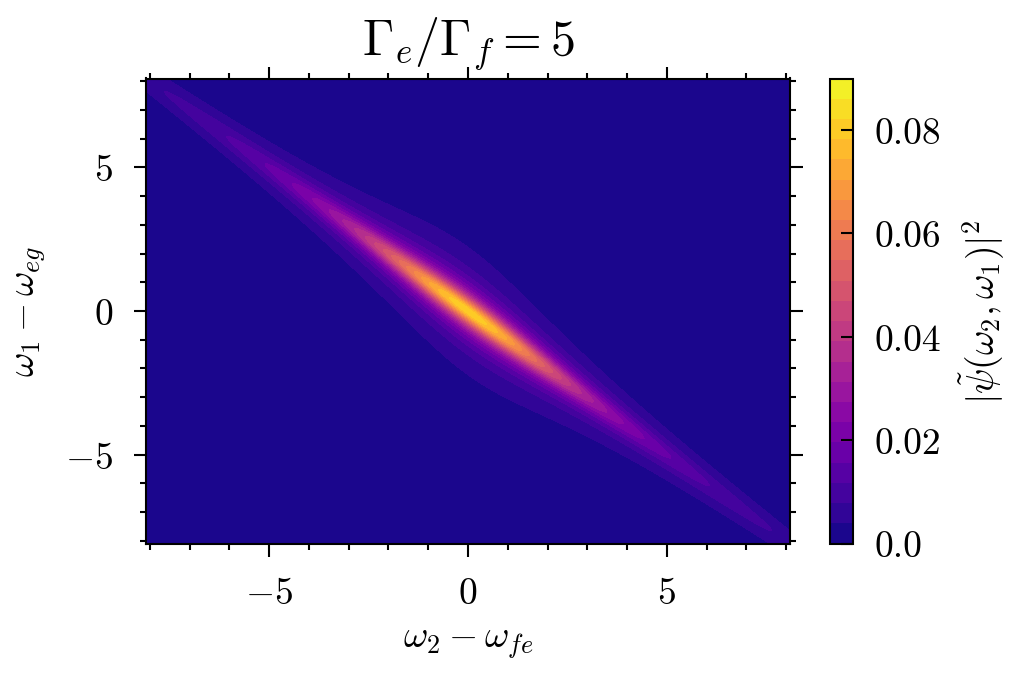

In [260]:
#############################3# Gamma_e = 0.5  ##########################################
w1 = np.linspace(-2.5,2.5,1000)
w2 = w1
Gamma_e, Gamma_f = 0.5, 1

Mu = 0

w_01 = 0
w_02 = 0
PSI = psi_w(w1, w2, Gamma_e = Gamma_e, Gamma_f = Gamma_f, w_01 = w_01, w_02 = w_02, Mu = Mu)
print(PSI.max())
PSI = plt.contourf(PSI, origin = 'lower',levels=np.linspace(0, 0.85, 24), extent=[w1.min(), w1.max(), w2.min(), w2.max()], aspect='auto', cmap='plasma')
plt.ylabel(r'$\omega_1 - \omega_{eg}$')
plt.xlabel(r'$\omega_2 - \omega_{fe}$')
cbar = plt.colorbar(PSI)
cbar.set_ticks(np.arange(0,0.9,0.2))
cbar.set_ticklabels(np.round(np.arange(0,0.9,0.2),2))
plt.tick_params(axis='both', which = 'both', direction = 'out')
cbar.set_label(r'$|\tilde{\psi}(\omega_2,\omega_1)|^2$')
plt.title(r'$\Gamma_e/\Gamma_f = 0.5$')
plt.savefig('Formula24_frequency_half.png')
plt.show()

#############################3# Gamma_e = 0.5  ##########################################
w1 = np.linspace(-2.5, 2.5, 1000)
w2 = w1
Gamma_e, Gamma_f = 1, 1

Mu = 0

w_01 = 0
w_02 = 0
PSI = psi_w(w1, w2, Gamma_e = Gamma_e, Gamma_f = Gamma_f, w_01 = w_01, w_02 = w_02, Mu = Mu)
print(PSI.max())
PSI = plt.contourf(PSI, origin = 'lower',levels=np.linspace(0, 0.45, 24), extent=[w1.min(), w1.max(), w2.min(), w2.max()], aspect='auto', cmap='plasma')
plt.ylabel(r'$\omega_1 - \omega_{eg}$')
plt.xlabel(r'$\omega_2 - \omega_{fe}$')
cbar = plt.colorbar(PSI)
cbar.set_ticks(np.arange(0,0.45,0.1))
cbar.set_ticklabels(np.round(np.arange(0,0.45,0.1),2))
plt.tick_params(axis='both', which = 'both', direction = 'out')
cbar.set_label(r'$|\tilde{\psi}(\omega_2,\omega_1)|^2$')
plt.title(r'$\Gamma_e/\Gamma_f = 1$')
plt.savefig('Formula24_frequency_1.png')
plt.show()

#############################3# Gamma_e = 0.5  ##########################################
w1 = np.linspace(-8.1,8.1,1000)
w2 = w1
Gamma_e, Gamma_f = 5, 1

Mu = 0

w_01 = 0
w_02 = 0
PSI = psi_w(w1, w2, Gamma_e = Gamma_e, Gamma_f = Gamma_f, w_01 = w_01, w_02 = w_02, Mu = Mu)
print(PSI.max())
PSI = plt.contourf(PSI, origin = 'lower',levels=np.linspace(0, 0.09, 24), extent=[w1.min(), w1.max(), w2.min(), w2.max()], aspect='auto', cmap='plasma')
plt.ylabel(r'$\omega_1 - \omega_{eg}$')
plt.xlabel(r'$\omega_2 - \omega_{fe}$')
cbar = plt.colorbar(PSI)
cbar.set_ticks(np.arange(0,0.09,0.02))
cbar.set_ticklabels(np.round(np.arange(0,0.09,0.02),2))
plt.tick_params(axis='both', which = 'both', direction = 'out')
cbar.set_label(r'$|\tilde{\psi}(\omega_2,\omega_1)|^2$')
plt.title(r'$\Gamma_e/\Gamma_f = 5$')
plt.savefig('Formula24_frequency_5.png')
plt.show()

0.5


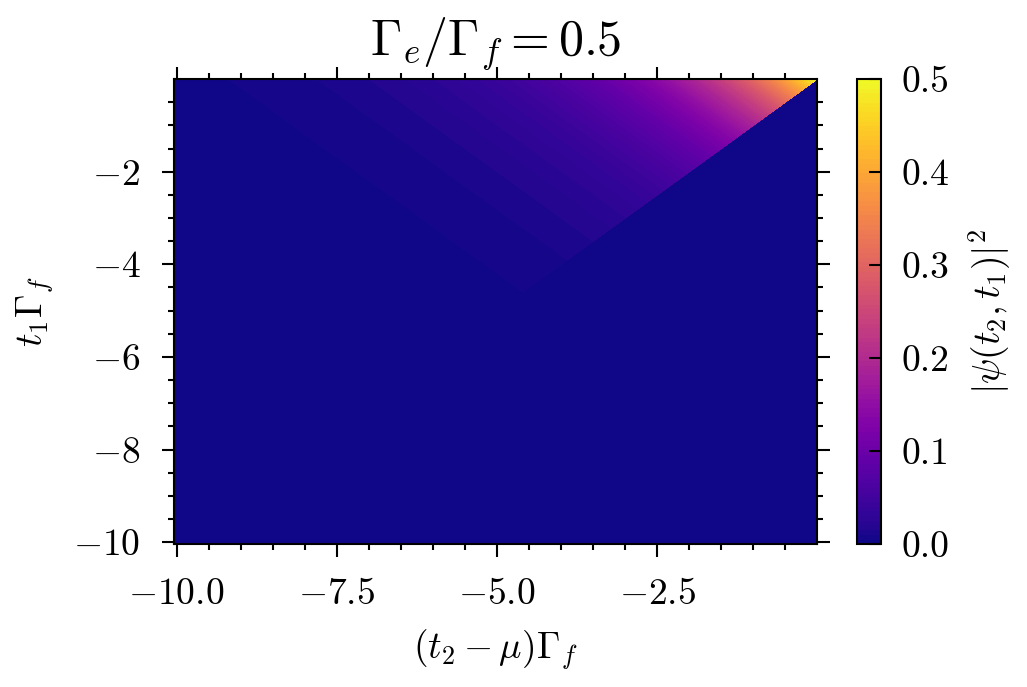

1.0


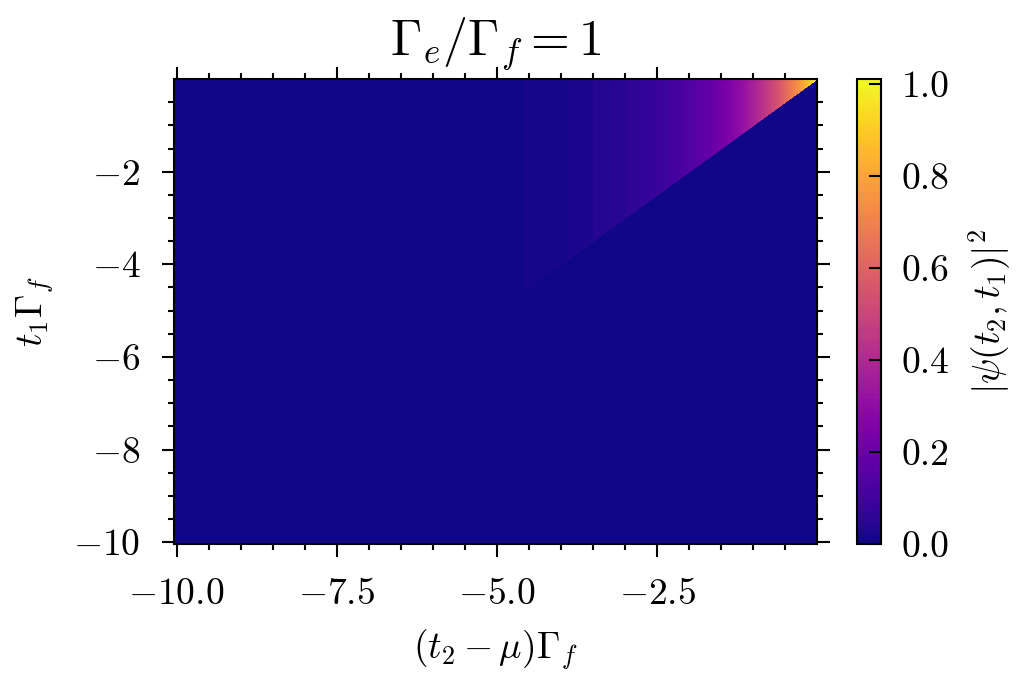

5.0


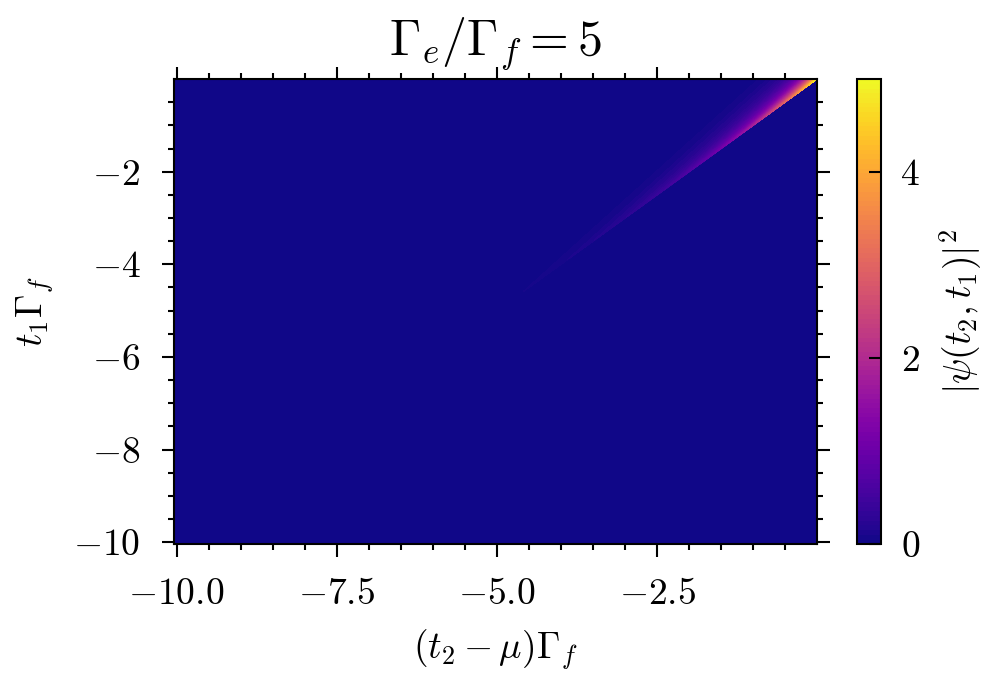

In [274]:
#############################3# Gamma_e = 0.5  ##########################################

t1 = np.linspace(-10.05,0,1000)
t2 = np.linspace(-10.05,0,1000)
# t2 = t1
Gamma_e, Gamma_f = 0.5, 1
Mu = 1.618855
Mu = 0

PSI = psi_t(t1, t2, Gamma_e = Gamma_e, Gamma_f = Gamma_f, Mu = Mu)
print(PSI.max())
PSI = plt.contourf(PSI, origin = 'lower', levels=np.linspace(0,0.5, 100), extent=[t1.min(), t1.max(), t2.min(), t2.max()], aspect='auto', cmap='plasma')
plt.ylabel(r'$t_1 \Gamma_f$')
plt.xlabel(r'$(t_2 - \mu)\Gamma_f$')
cbar = plt.colorbar(PSI)
cbar.set_ticks(np.arange(0,.51,0.1))
cbar.set_ticklabels(np.round(np.arange(0,0.51,0.1),2))
# plt.plot([-2.5,2.1],[-2.5+Mu,2.1+Mu],'--')
plt.tick_params(axis='both', which = 'both', direction = 'out')
cbar.set_label(r'$|\psi(t_2,t_1)|^2$')
plt.title(r'$\Gamma_e/\Gamma_f = 0.5$')
plt.savefig('Formula21_time_half.png')



plt.show()#############################3# Gamma_e = 1  ##########################################

t1 = np.linspace(-10.05,0,1000)
t2 = np.linspace(-10.05,0,1000)
# t2 = t1
Gamma_e, Gamma_f = 1, 1
Mu = 1.618855
Mu = 0

PSI = psi_t(t1, t2, Gamma_e = Gamma_e, Gamma_f = Gamma_f, Mu = Mu)
print(PSI.max())
PSI = plt.contourf(PSI, origin = 'lower', levels=np.linspace(0,1.01, 100), extent=[t1.min(), t1.max(), t2.min(), t2.max()], aspect='auto', cmap='plasma')
plt.ylabel(r'$t_1 \Gamma_f$')
plt.xlabel(r'$(t_2 - \mu)\Gamma_f$')
cbar = plt.colorbar(PSI)
cbar.set_ticks(np.arange(0,1.01,0.2))
cbar.set_ticklabels(np.round(np.arange(0,1.01,0.2),2))
# plt.plot([-2.5,2.1],[-2.5+Mu,2.1+Mu],'--')
plt.tick_params(axis='both', which = 'both', direction = 'out')
cbar.set_label(r'$|\psi(t_2,t_1)|^2$')
plt.title(r'$\Gamma_e/\Gamma_f = 1$')
plt.savefig('Formula21_time_1.png')


plt.show()#############################3# Gamma_e = 5  ##########################################

t1 = np.linspace(-10.05,0,1000)
t2 = np.linspace(-10.05,0,1000)
# t2 = t1
Gamma_e, Gamma_f = 5, 1
Mu = 1.618855
Mu = 0

PSI = psi_t(t1, t2, Gamma_e = Gamma_e, Gamma_f = Gamma_f, Mu = Mu)
print(PSI.max())
PSI = plt.contourf(PSI, origin = 'lower', levels=np.linspace(0,5, 100), extent=[t1.min(), t1.max(), t2.min(), t2.max()], aspect='auto', cmap='plasma')
plt.ylabel(r'$t_1 \Gamma_f$')
plt.xlabel(r'$(t_2 - \mu)\Gamma_f$')
cbar = plt.colorbar(PSI)
cbar.set_ticks(np.arange(0, 5, 2))
cbar.set_ticklabels(np.round(np.arange(0, 5, 2),2))
# plt.plot([-2.5,2.1],[-2.5+Mu,2.1+Mu],'--')
plt.tick_params(axis='both', which = 'both', direction = 'out')
cbar.set_label(r'$|\psi(t_2,t_1)|^2$')
plt.title(r'$\Gamma_e/\Gamma_f = 5$')
plt.savefig('Formula21_time_5.png')
plt.show()

In [235]:
PSI = psi_t(t1, t2, Gamma_e = Gamma_e, Gamma_f = Gamma_f, Mu = Mu)

PSI.sum()*np.diff(t1)[0]**2
# PSI.sum()*np.diff(t1)[0]
# PSI.sum()

# print((PSI.sum())*np.diff(PSI)[0])


np.float64(23505.363896463263)

AttributeError: 'QuadContourSet' object has no attribute 'shape'

## Omega ratio Vs Gammas

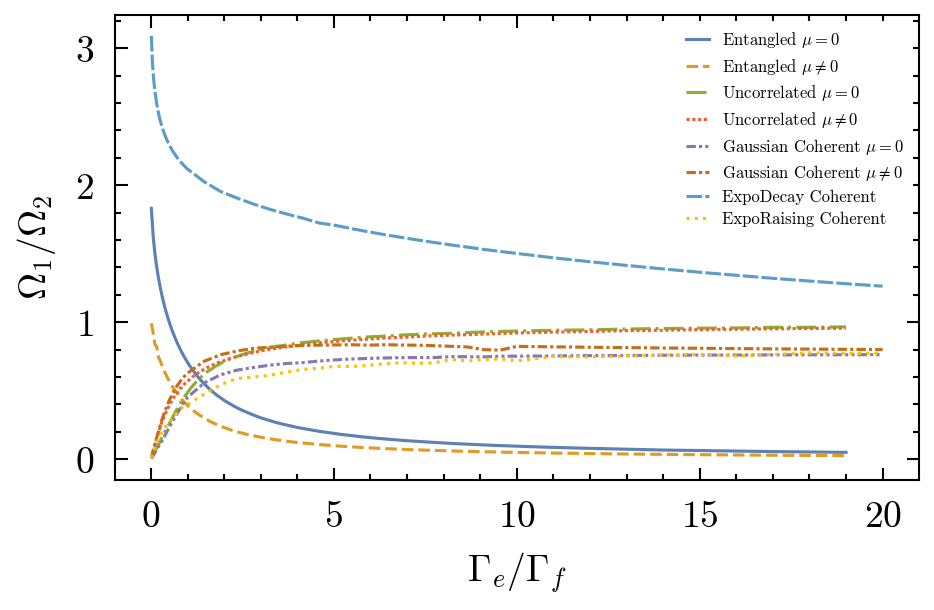

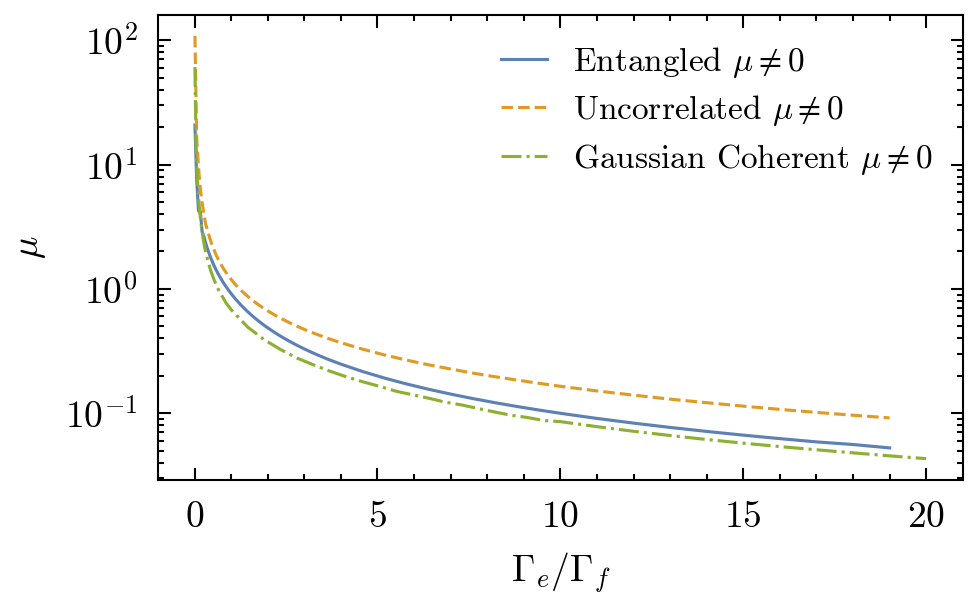

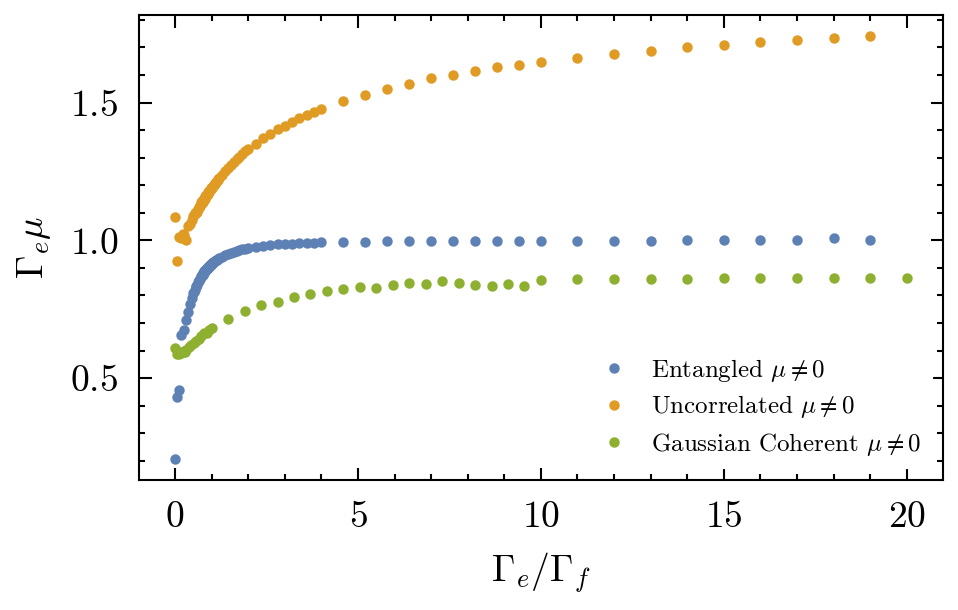

In [213]:
df_Ent = pd.read_csv('dataSet/paper/P_Entangled_Gaussian.csv')
df_Ent_Mu = pd.read_csv('dataSet/paper/P_Entangled_Gaussian_Mu.csv')
df_Uncor = pd.read_csv('dataSet/paper/P_Gaussian_Uncor.csv')
df_Uncor_Mu = pd.read_csv('dataSet/paper/P_Gaussian_Uncor_Mu.csv')
data_ExpoDecay = pd.read_csv('dataSet/paper/P_Coherent_ExpoDecay.csv')
data_ExpoRaising = pd.read_csv('dataSet/paper/P_Coherent_ExpoRaising.csv')
data_Gaussian = pd.read_csv('dataSet/paper/P_Coherent_Gaussian.csv')
data_Gaussian_Mu = pd.read_csv('dataSet/paper/P_Coherent_Gaussian_Mu.csv')


plt.plot(df_Ent['Gamma_e'],df_Ent['Omega_1']/df_Ent['Omega_2'],label = r'Entangled $\mu = 0$')
plt.plot(df_Ent_Mu['Gamma_e'],df_Ent_Mu['Omega_1']/df_Ent_Mu['Omega_2'],label = r'Entangled $\mu \neq 0$')
plt.plot(df_Uncor['Gamma_e'][:-3],df_Uncor['Omega_1'][:-3]/df_Uncor['Omega_2'][:-3],label = r'Uncorrelated $\mu = 0$')
plt.plot(df_Uncor_Mu['Gamma_e'][:-3],df_Uncor_Mu['Omega_1'][:-3]/df_Uncor_Mu['Omega_2'][:-3],label = r'Uncorrelated $\mu \neq 0$')
plt.plot(data_Gaussian['Gamma_e'][:-3],data_Gaussian['Omega_1'][:-3]/data_Gaussian['Omega_2'][:-3],label = r'Gaussian Coherent $\mu = 0$')
plt.plot(data_Gaussian_Mu['Gamma_e'][:-3],data_Gaussian_Mu['Omega_1'][:-3]/data_Gaussian_Mu['Omega_2'][:-3],label = r'Gaussian Coherent $\mu \neq 0$')
# plt.plot(data_ExpoDecay['Gamma_e'][:-3],data_ExpoDecay['Omega_1'][:-3]/data_ExpoDecay['Omega_2'][:-3],label = r'ExpoDecay Coherent')
# plt.plot(data_ExpoRaising['Gamma_e'][:-3],data_ExpoRaising['Omega_1'][:-3]/data_ExpoRaising['Omega_2'][:-3],label = r'ExpoRaising Coherent')
plt.xlabel(r'$\Gamma_e/\Gamma_f$')
plt.ylabel(r'$\Omega_1/\Omega_2$')

plt.legend(fontsize = 4)
plt.savefig('dataSet/paper/Omega_vs_Gamma.png', dpi = 300)
plt.show()


plt.semilogy(df_Ent_Mu['Gamma_e'],df_Ent_Mu['Mu'],label = r'Entangled $\mu \neq 0$')
plt.semilogy(df_Uncor_Mu['Gamma_e'][:-3],df_Uncor_Mu['Mu'][:-3],label = r'Uncorrelated $\mu \neq 0$')
plt.semilogy(data_Gaussian_Mu['Gamma_e'][:-3],data_Gaussian_Mu['Mu'][:-3],label = r'Gaussian Coherent $\mu \neq 0$')
plt.xlabel(r'$\Gamma_e/\Gamma_f$')
plt.ylabel(r'$\mu$')

plt.legend()
plt.savefig('dataSet/paper/Mu_vs_Gamma_log.png', dpi = 300)
plt.show()


plt.plot(df_Ent_Mu['Gamma_e'],df_Ent_Mu['Mu']*df_Ent_Mu['Gamma_e'], '.', label = r'Entangled $\mu \neq 0$')
plt.plot(df_Uncor_Mu['Gamma_e'][:-3],df_Uncor_Mu['Mu'][:-3]*df_Uncor_Mu['Gamma_e'][:-3], '.', label = r'Uncorrelated $\mu \neq 0$')
plt.plot(data_Gaussian_Mu['Gamma_e'][:-3],data_Gaussian_Mu['Mu'][:-3]*data_Gaussian_Mu['Gamma_e'][:-3], '.', label = r'Gaussian Coherent $\mu \neq 0$')
plt.xlabel(r'$\Gamma_e/\Gamma_f$')
plt.ylabel(r'$\Gamma_e\mu$')

plt.legend(fontsize = 6)
plt.savefig('dataSet/paper/GammaMu_vs_Gamma.png', dpi = 300)
plt.show()

In [173]:
df_Ent

,P_max,Omega_1,Omega_2,Gamma_e,Shannon
0,0.029309,0.173924,0.094950,0.010,0.463929
1,0.119132,0.338640,0.207583,0.059,0.337124
2,0.173293,0.429505,0.286389,0.108,0.252209
3,0.210949,0.491693,0.350479,0.157,0.190203
4,0.238896,0.543759,0.411669,0.206,0.139093
...,...,...,...,...,...
95,0.389154,1.032280,16.225047,15.000,3.418959
96,0.389173,1.030898,17.303896,16.000,3.513526
97,0.389326,1.018765,18.219075,17.000,3.604755
98,0.389204,1.034201,19.465250,18.000,3.678365


# 
#### Result for <mark> Gaussian coherent </mark> pulse with $\Gamma_e = 0.001$:

As you see there is no going to zero in this limit


<span style='color:yellow'>$P_{max}$ &nbsp;  : 0.10170051960309295</span>

$\Omega_1$ &nbsp;   : 0.0014241614616988568

$\Omega_2$  &nbsp; : 0.4549609964165894

$\mu = 0$

<hr>


#### Result for <mark> Gaussian Uncorrelated </mark> pulse with $\Gamma_e = 0.001$:

As you see there is no going to zero in this limit



<span style='color:yellow'>$P_{max}$ &nbsp;  : 0.35656715882284507</span>

$\Gamma_e = 0.001$

$\Omega_1$ &nbsp;   : 0.0007645776670089626

$\Omega_2$  &nbsp; : 0.8287381857204438

$\mu = 0$
